# day 4-1

このノートブックの実行例は[こちら(HTML版)](lecture-gssm2025/notebooks-sample/day-4-1.html)で確認できます

---

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np

# 再現性のために乱数を固定する
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

## 0. 準備

### 0.1 必要なパッケージのインストール

In [2]:
%%capture
!sudo apt-get update
!sudo apt-get install -y automake autoconf perl libtool graphviz libgraphviz-dev
!pip install -U japanize_matplotlib pyvis pygraphviz mca

教材のダウンロード

In [3]:
!git clone https://github.com/haradatm/lecture-gssm2025

Cloning into 'lecture-gssm2025'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 355.10 KiB | 9.60 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ln -s lecture-gssm2025/notebooks/gssm_utils.py .

ln: failed to create symbolic link './gssm_utils.py': File exists


### 0.2 MeCab インストール (時間目安: 約3分)

In [5]:
%%time
!bash lecture-gssm2025/scripts/install_mecab.sh >> install_mecab.log 2>&1
!tail -n 1 install_mecab.log

CPU times: user 1.01 s, sys: 151 ms, total: 1.16 s
Wall time: 2min 48s


### 0.3 CaboCha インストール (時間目安: 約4分)

In [6]:
%%time
!bash lecture-gssm2025/scripts/install_cabocha.sh >> install_cabocha.log 2>&1
!tail -n 1 install_cabocha.log

CPU times: user 1.6 s, sys: 202 ms, total: 1.8 s
Wall time: 4min 12s


### 0.4 セッションの再起動

In [ ]:
import os
os.kill(os.getpid(), 9)

### 0.5 動作確認

In [1]:
import MeCab
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc")
print(tagger.parse("今日はいい天気です"))

今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



In [2]:
import CaboCha
cp = CaboCha.Parser("-r ./tools/usr/local/etc/cabocharc")
tree = cp.parse("今日はいい天気です")
print(tree.toString(CaboCha.FORMAT_LATTICE))

* 0 2D 0/1 -1.041733
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.041733
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
* 2 -1D 0/1 0.000000
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



---

## 1. テキスト分析 (1)

### 1.0 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [3]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

%matplotlib inline

### 1.1 データのダウンロード

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2024-2025.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2024/1~2025 GW明け | 本講義の全体を通して使用する |

In [4]:
# rakuten-1000-2024-2025.xlsx.zip をダウンロードする
FILE_ID = "1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS"
!gdown {FILE_ID}
!unzip -o rakuten-1000-2024-2025.xlsx.zip

Downloading...
From: https://drive.google.com/uc?id=1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS
To: /content/rakuten-1000-2024-2025.xlsx.zip
100% 2.61M/2.61M [00:00<00:00, 119MB/s]
Archive:  rakuten-1000-2024-2025.xlsx.zip
  inflating: rakuten-1000-2024-2025.xlsx  


### 1.2 データの読み込み (DataFrame型)

In [5]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2024-2025.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 19)


カテゴリー    エリア    施設番号                            施設名  \
0  A_レジャー  01_登別   29995                        ゆとりろ洞爺湖   
1  A_レジャー  01_登別    9691                  登別温泉　ホテルゆもと登別   
2  A_レジャー  01_登別   40708                  虎杖浜温泉　ホテル　いずみ   
3  A_レジャー  01_登別  139962          ザ　レイクビュー　ＴＯＹＡ　乃の風リゾート   
4  A_レジャー  01_登別  168374  虎杖浜天然温泉　「旅人の湯」ホテルルートインＧｒａｎｄ室蘭   

                                                コメント  総合  サービス  立地  部屋  \
0                                      わんこと泊まれて良かった！   3     3   3   3   
1  古い建物ですがきれいにしている感じでした。入った瞬間においが気になりましたが、タバコのにおい...   5     5   5   4   
2  3月15日に初めて宿泊させて頂きました。予約プランは和室6畳でしたが、空きがあるとのことで1...   5     5   5   5   
3  大きめ柴犬と宿泊しましたが、部屋は充分な広さでした夕朝食のブッフェも、種類豊富で美味しかった...   4     5   5   4   
4  コーヒー無料サービスが嬉しい。水のペットボトルサービスがあるとさらに良い（最近デフォルトのビ...   4     3   4   4   

   設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月        投稿者   年代  性別           投稿日  
0       3.0  4.0  3.0  レジャー  家族  45413        投稿者   na  na  45445.668553  
1       5.0  4.0  5.0  レジャー  家族  45474  mamemama3  40代  女性  45499.742442  
2       5.0  5.0  5.0  レジャー  家族  45717     ハコ9437  40代  女性  45733.810486  
3       4.0  4.0  5.0  レジャー  家族  45413        投稿者   na  na  45440.662477  
4       3.0  3.0  NaN  ビジネス  一人  45505        投稿者   na  na  45529.484410

### 1.3 単語の抽出

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [6]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(151626, 6)


文書ID    表層    品詞   カテゴリー    エリア      dict_key
0     1    わん    名詞  A_レジャー  01_登別      (わん, 名詞)
1     1    良い   形容詞  A_レジャー  01_登別     (良い, 形容詞)
2     2    古い   形容詞  A_レジャー  01_登別     (古い, 形容詞)
3     2    建物    名詞  A_レジャー  01_登別      (建物, 名詞)
4     2  きれいだ  形容動詞  A_レジャー  01_登別  (きれいだ, 形容動詞)

### 1.4 単語の出現回数 (Top 75)

単語の出現回数をカウントする

In [7]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]
word_counts_df = pd.DataFrame(word_list, columns=columns)

# DataFrame を表示する
print(word_counts_df.shape)
display(word_counts_df.head(10))

(8746, 4)


単語ID    表層  出現頻度     dict_key
0     0    部屋  6363     (部屋, 名詞)
1     1    良い  5242    (良い, 形容詞)
2     2   ホテル  2792    (ホテル, 名詞)
3     3    風呂  2688     (風呂, 名詞)
4     4  美味しい  2290  (美味しい, 形容詞)
5     5    ない  2176    (ない, 形容詞)
6     6    温泉  1836     (温泉, 名詞)
7     7  スタッフ  1623   (スタッフ, 名詞)
8     8    立地  1434     (立地, 名詞)
9     9    よい  1411    (よい, 形容詞)

単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [8]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# DataFrame を表示する
print(docs_150_df.shape)
display(docs_150_df)

(84359, 7)


文書ID  単語ID    表層    品詞   カテゴリー    エリア      dict_key
0          1     1    良い   形容詞  A_レジャー  01_登別     (良い, 形容詞)
1          2    39    古い   形容詞  A_レジャー  01_登別     (古い, 形容詞)
2          2    76    建物    名詞  A_レジャー  01_登別      (建物, 名詞)
3          2    59  きれいだ  形容動詞  A_レジャー  01_登別  (きれいだ, 形容動詞)
4          2    27    感じ    名詞  A_レジャー  01_登別      (感じ, 名詞)
...      ...   ...   ...   ...     ...    ...           ...
84354  10000    25     気    名詞  B_ビジネス  10_福岡       (気, 名詞)
84355  10000     3    風呂    名詞  B_ビジネス  10_福岡      (風呂, 名詞)
84356  10000     0    部屋    名詞  B_ビジネス  10_福岡      (部屋, 名詞)
84357  10000    40     人    名詞  B_ビジネス  10_福岡       (人, 名詞)
84358  10000    40     人    名詞  B_ビジネス  10_福岡       (人, 名詞)

[84359 rows x 7 columns]

### 1.5 ワードクラウド

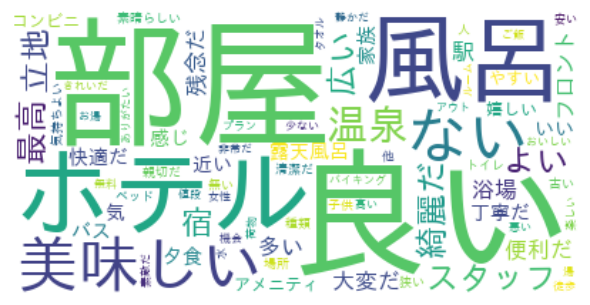

In [9]:
# 出現回数Top 75単語でワードクラウドを作成する
words = ' '.join(word_counts_df['表層'][0:75])
gssm_utils.plot_wordcloud(words)

### 1.6 「文書-抽出語」表の作成

「文書-抽出語」表を作成する (出現回数 Top 75語)

In [10]:
# 「単語出現回数」 表から出現回数Top 75語のみ抽出する
word_counts_75_df = word_counts_df[0:75]

# 「文書-抽出語」 表も出現回数Top 75語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_75_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_75_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_75_df = pd.crosstab(
    [
        docs_75_df['カテゴリー'],
        docs_75_df['エリア'],
        docs_75_df['文書ID']
    ],
    docs_75_df['単語ID'], margins=False
)
cross_75_df.columns = word_counts_75_df["表層"]

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9616, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   4    1   0     0   1   1     1   0   0  ...   0   0   
             4       2   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   2    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     3   0   0  ...   0   0   
             9999    1   1    1   2     0   1   0     0   0   0  ...   0   0   
             10000   2   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0    0   0    0   0    0  0  
             2          0    0    0   0    0   0    0  0  
             3          0    0    0   0    0   0    0  0  
             4          0    0    0   0    1   0    0  0  
             5          0    0    0   0    0   0    0  1  
...                   ...  ...  ...  ..  ...  ..  ... ..  
B_ビジネス 10_福岡 9996       0    0    0   0    0   0    0  3  
             9997       0    0    0   0    0   0    0  0  
             9998       0    0    0   0    0   0    0  0  
             9999       0    0    0   0    0   0    0  0  
             10000      0    0    0   0    0   0    0  0  

[9616 rows x 75 columns]

「文書-抽出語」 表を {0,1} に変換する

In [11]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_75_df[cross_75_df > 0] = 1

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9616, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4       1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   1    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     1   0   0  ...   0   0   
             9999    1   1    1   1     0   1   0     0   0   0  ...   0   0   
             10000   1   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0    0   0    0   0    0  0  
             2          0    0    0   0    0   0    0  0  
             3          0    0    0   0    0   0    0  0  
             4          0    0    0   0    1   0    0  0  
             5          0    0    0   0    0   0    0  1  
...                   ...  ...  ...  ..  ...  ..  ... ..  
B_ビジネス 10_福岡 9996       0    0    0   0    0   0    0  1  
             9997       0    0    0   0    0   0    0  0  
             9998       0    0    0   0    0   0    0  0  
             9999       0    0    0   0    0   0    0  0  
             10000      0    0    0   0    0   0    0  0  

[9616 rows x 75 columns]

### 1.7 共起ネットワーク図

#### 1.7.1 共起度行列を作成する (抽出語-抽出語)

In [12]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

# 共起行列を作成する
X = cross_75_df.values
X = csc_matrix(X)
Xc = (X.T * X)
# 対角成分のみにする
Xc = np.triu(Xc.toarray())

# DataFrame 型に整える
cooccur_75_df = pd.DataFrame(Xc, columns=cross_75_df.columns, index=cross_75_df.columns)

# DataFrame を表示する
print(cooccur_75_df.shape)
display(cooccur_75_df.head())

(75, 75)


表層      部屋    良い   ホテル    風呂  美味しい   ない   温泉  スタッフ   立地   よい  ...   お湯   徒歩  \
表層                                                            ...             
部屋    4390  1877  1032  1267  1055  989  708   777  666  655  ...  191  170   
良い       0  3703   873  1000   889  689  682   694  758  329  ...  164  160   
ホテル      0     0  1996   438   380  477  277   358  353  257  ...   58  109   
風呂       0     0     0  2142   634  513  366   363  301  344  ...  154   86   
美味しい     0     0     0     0  2023  360  469   420  247  281  ...  101   76   

表層    ありがたい  タオル  少ない   女性  楽しい   安い  ルーム    水  
表層                                              
部屋      179  167  187  145  175  151  159  176  
良い      116  112  139  138  115  126  120  122  
ホテル      81   84   94   88   69   87   98   68  
風呂       84   82  103   80   90   67   54   96  
美味しい     67   54  107   60  113   43   43   59  

[5 rows x 75 columns]

#### 1.7.2 Jaccard 係数を求める (抽出語-抽出語)

In [13]:
# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_75_df = gssm_utils.jaccard_coef(cooccur_75_df, cross_75_df)

# DataFrame を表示する
print(jaccard_75_df.shape)
display(jaccard_75_df.head())

(75, 75)


表層     部屋        良い       ホテル        風呂      美味しい        ない        温泉  \
表層                                                                      
部屋    0.0  0.301963  0.192753  0.240646  0.196902  0.195764  0.139315   
良い    0.0  0.000000  0.180895  0.206398  0.183792  0.147696  0.154264   
ホテル   0.0  0.000000  0.000000  0.118378  0.104424  0.150473  0.088811   
風呂    0.0  0.000000  0.000000  0.000000  0.179553  0.156402  0.115239   
美味しい  0.0  0.000000  0.000000  0.000000  0.000000  0.108630  0.158768   

表層        スタッフ        立地        よい  ...        お湯        徒歩     ありがたい  \
表層                                  ...                                 
部屋    0.155899  0.130129  0.132914  ...  0.042379  0.037437  0.039514   
良い    0.158447  0.174695  0.072039  ...  0.042631  0.041408  0.029698   
ホテル   0.118976  0.116233  0.087653  ...  0.025824  0.049366  0.036258   
風呂    0.115238  0.093045  0.115012  ...  0.067073  0.036180  0.035339   
美味しい  0.141224  0.077918  0.095741  ...  0.045291  0.033510  0.029451   

表層         タオル       少ない        女性       楽しい        安い       ルーム         水  
表層                                                                          
部屋    0.037335  0.041445  0.031924  0.038751  0.033238  0.035365  0.039224  
良い    0.029159  0.035889  0.035733  0.029571  0.032466  0.031185  0.031655  
ホテル   0.038853  0.042515  0.039909  0.030969  0.039313  0.045307  0.030895  
風呂    0.035498  0.043867  0.033913  0.038249  0.028163  0.022949  0.041397  
美味しい  0.024335  0.048090  0.026549  0.051108  0.018827  0.019154  0.026375  

[5 rows x 75 columns]

#### 1.7.3 プロットする

<Figure size 800x800 with 0 Axes>

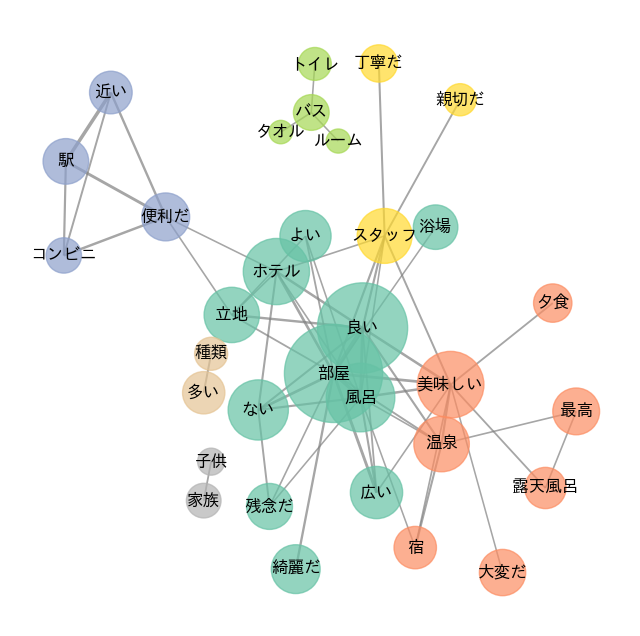

In [14]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(Jaccard係数)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(jaccard_75_df, word_counts, np.sort(jaccard_75_df.values.reshape(-1))[::-1][60])

### 1.8 係り受けネットワーク図

#### 1.8.1 係り受け行列を作成する

In [ ]:
# チャンク(文節)から単語を取り出す
def get_words(tree, from_chunk, stopwords):

    # チャンク(文節)の開始位置を取得する
    beg = from_chunk.token_pos

    # チャンクの開始位置を取得する
    end = from_chunk.token_pos + from_chunk.token_size

    # 抽出語情報リストの初期化
    words = []

    # チャンク(文節)ごとのループ
    for i in range(beg, end):

        # チャンク中の形態素を取り出す
        token = tree.token(i)

        # 解析結果を要素ごとにバラす
        features = token.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

    # 抽出語情報をリストを返却する
    return words


# 必要ライブラリのインポート
import CaboCha

# cabocha の初期化
cp = CaboCha.Parser("-r ./tools/usr/local/etc/cabocharc")

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ['*']  # 原形に 「'*'」 が出力された場合に除去するため

# 係り受けペア辞書の初期化
pair_counts = defaultdict(lambda: 0)
pairs = []

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, cabocha で解析する
    tree = cp.parse(row["コメント"].translate(HAN2ZEN))

    # 解析結果から空でないチャンク(文節)のリストを集める
    chunks = {}
    key = 0
    for i in range(tree.size()):
        tok = tree.token(i)
        if tok.chunk:
            chunks[key] = tok.chunk
            key += 1

    # 係り元と係り先の単語情報(原形と品詞)を集める
    from_words, to_words = [], []
    for from_chunk in chunks.values():
        # 係り先がなければスキップ
        if from_chunk.link < 0:
            continue

        # 係り先のチャンク(文節)を取得する
        to_chunk = chunks[from_chunk.link]

        # 係り元の単語情報(原形と品詞)を取得する
        from_words = get_words(tree, from_chunk, stopwords)

        # 係り先の単語情報(原形と品詞)を取得する
        to_words = get_words(tree, to_chunk, stopwords)

    # 係り受けペアと頻度を収集する
    for f in from_words:
        for t in to_words:
            key = (f[0], t[0])
            pair_counts[key] += 1


# 係り受け行列を初期化する (共起行列と同じ形)
Xd = np.zeros(cooccur_75_df.shape)

# 係り受けペアを係り受け列に変換する
for (f,t), v in pair_counts.items():
    columns = list(cooccur_75_df.columns)
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)
        Xd[i,j] = v

# DataFrme 型に整える
dep_75_df = pd.DataFrame(Xd, columns=cooccur_75_df.columns, index=cooccur_75_df.columns)
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層     部屋    良い   ホテル   風呂  美味しい   ない   温泉  スタッフ   立地   よい  ...   お湯   徒歩  \
表層                                                          ...             
部屋    0.0  10.0   0.0  0.0   0.0  1.0  0.0   0.0  0.0  2.0  ...  0.0  0.0   
良い    1.0   2.0  27.0  0.0   0.0  1.0  1.0   0.0  2.0  0.0  ...  1.0  0.0   
ホテル   0.0   0.0   0.0  0.0   1.0  1.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
風呂    0.0  15.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0  5.0  ...  0.0  0.0   
美味しい  0.0   0.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   

表層    ありがたい  タオル  少ない   女性  楽しい   安い  ルーム    水  
表層                                              
部屋      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
良い      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
ホテル     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
風呂      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
美味しい    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 75 columns]

#### 1.8.2 条件付き確率を求める

In [31]:
# 係り受け行列の中身(numpy行列)を取り出す
Xc = dep_75_df.values

# 係り受け行列(条件付き確率)を初期化する (元の係り受け行列と同じ形)
Xd = np.zeros(Xc.shape)

# 係り元単語の出現頻度を取得する
word_counts = cooccur_75_df.sum(axis=0).values

# 係り受けペアごとのループ
for (f,t), v in pair_counts.items():
    columns = list(dep_75_df.columns)

    # 係り元と係り先の両方が列に含まれる
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)

        # 条件付き確率(係り受け頻度/係り先出現回数)を求める
        Xd[i,j] = v / word_counts[i]

# DataFrame 型に整える
dep_75_df = pd.DataFrame(Xd, columns=dep_75_df.columns, index=dep_75_df.columns)

# DataFrame を表示する
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層          部屋        良い       ホテル   風呂      美味しい        ない        温泉  スタッフ  \
表層                                                                            
部屋    0.000000  0.002278  0.000000  0.0  0.000000  0.000228  0.000000   0.0   
良い    0.000179  0.000358  0.004839  0.0  0.000000  0.000179  0.000179   0.0   
ホテル   0.000000  0.000000  0.000000  0.0  0.000256  0.000256  0.000000   0.0   
風呂    0.000000  0.003095  0.000000  0.0  0.000000  0.000000  0.000000   0.0   
美味しい  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   0.0   

表層          立地        よい  ...        お湯   徒歩     ありがたい  タオル  少ない   女性  楽しい  \
表層                        ...                                                
部屋    0.000000  0.000456  ...  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
良い    0.000358  0.000000  ...  0.000179  0.0  0.000000  0.0  0.0  0.0  0.0   
ホテル   0.000000  0.000000  ...  0.000000  0.0  0.000256  0.0  0.0  0.0  0.0   
風呂    0.000000  0.001032  ...  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
美味しい  0.000000  0.000000  ...  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   

表層     安い  ルーム    水  
表層                   
部屋    0.0  0.0  0.0  
良い    0.0  0.0  0.0  
ホテル   0.0  0.0  0.0  
風呂    0.0  0.0  0.0  
美味しい  0.0  0.0  0.0  

[5 rows x 75 columns]

#### 1.8.3 プロットする

pyvis.html


<Figure size 800x800 with 0 Axes>

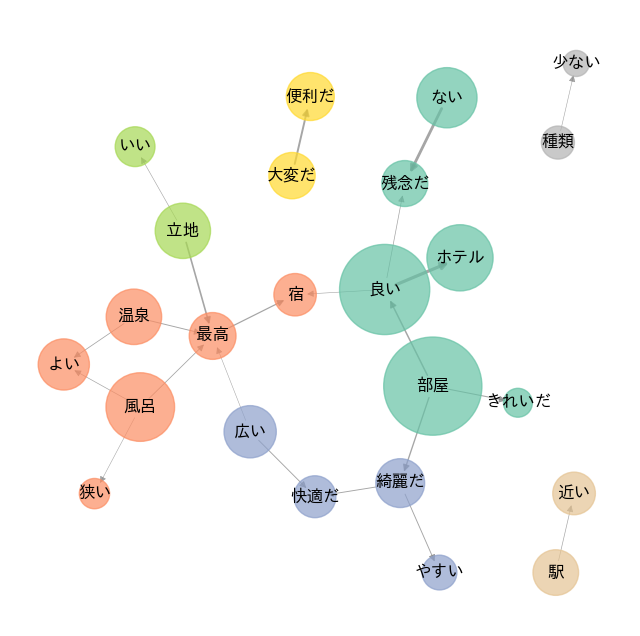

In [32]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 係り受け(条件付き確率)で共起ネットワーク図を作成する
gssm_utils.plot_dependency_network(dep_75_df, word_counts, np.sort(dep_75_df.values.reshape(-1))[::-1][60], pyvis=True)

### 1.9 対応分析

「文書-抽出語」 表を確認する

In [33]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(9616, 75)


表層                 部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                               ...           
A_レジャー 01_登別 1      0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2      1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3      1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4      1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5      0   1    1   0     0   0   0     0   0   0  ...   0   0   

表層                 ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                        
A_レジャー 01_登別 1         0    0    0   0    0   0    0  0  
             2         0    0    0   0    0   0    0  0  
             3         0    0    0   0    0   0    0  0  
             4         0    0    0   0    1   0    0  0  
             5         0    0    0   0    0   0    0  1  

[5 rows x 75 columns]

#### 1.9.1 「外部変数-抽出語」 クロス集計表を作成する

In [34]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_75_df = pd.concat(
    [
        cross_75_df.groupby(level='カテゴリー').sum(),
        cross_75_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_75_df.shape)
display(aggregate_75_df)

(12, 75)


表層        部屋    良い   ホテル    風呂  美味しい   ない    温泉  スタッフ   立地   よい  ...   お湯  \
A_レジャー  2325  2054   753  1474  1504  890  1292   856  550  648  ...  235   
B_ビジネス  2065  1649  1243   668   519  761   108   515  844  545  ...   73   
01_登別    435   398   157   301   269  185   267   118   57  109  ...   46   
02_草津    481   441   168   362   289  197   287   193  161  141  ...   61   
03_箱根    510   450   166   287   351  188   220   195   57  142  ...   45   
04_道後    380   366   218   190   202  150   257   103  164  136  ...   29   
05_湯布院   519   399    44   334   393  170   261   247  111  120  ...   54   
06_札幌    399   324   263   118   145  142    27   102  170  105  ...   12   
07_名古屋   388   334   243   147    95  161    26   125  145  115  ...   20   
08_東京    416   333   224   133    80  155    15    99  170   96  ...   19   
09_大阪    423   305   252   126    88  145    19    96  171  118  ...   13   
10_福岡    439   353   261   144   111  158    21    93  188  111  ...    9   

表層       徒歩  ありがたい  タオル  少ない   女性  楽しい   安い  ルーム    水  
A_レジャー  141    149  132  185  152  235  110   71  128  
B_ビジネス  180    170  118  124  145   66  194  194  145  
01_登別    15     32   32   36   26   41   16   19   28  
02_草津    51     24   15   39   22   49   26   11   31  
03_箱根    24     32   28   43   38   52   15   20   28  
04_道後    22     30   34   27   29   28   38   15   17  
05_湯布院   29     31   23   40   37   65   15    6   24  
06_札幌    35     38   27   18   22   21   33   37   21  
07_名古屋   33     33   25   34   34   11   36   38   30  
08_東京    32     35   21   19   34    9   39   39   29  
09_大阪    34     34   23   22   34   16   42   42   38  
10_福岡    46     30   22   31   21    9   44   38   27  

[12 rows x 75 columns]

#### 1.9.2 対応分析プロットを作成する

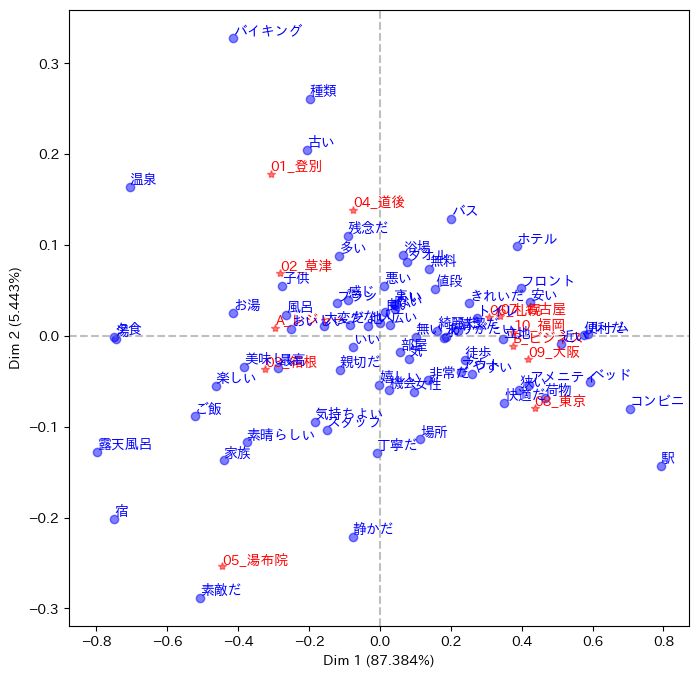

In [35]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_75_df.shape[1]
mca_ben = mca.MCA(aggregate_75_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord, row_labels, col_labels, explained_inertia)

### 1.10 トピックモデル

「文書-抽出語」 表を確認する

In [36]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(9616, 75)


表層                 部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                               ...           
A_レジャー 01_登別 1      0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2      1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3      1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4      1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5      0   1    1   0     0   0   0     0   0   0  ...   0   0   

表層                 ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                        
A_レジャー 01_登別 1         0    0    0   0    0   0    0  0  
             2         0    0    0   0    0   0    0  0  
             3         0    0    0   0    0   0    0  0  
             4         0    0    0   0    1   0    0  0  
             5         0    0    0   0    0   0    0  1  

[5 rows x 75 columns]

#### 1.10.1 トピックを抽出する (LDA)

In [37]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=42, n_jobs=-1, n_components=6)
lda.fit(cross_75_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_75_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

Topic # 1: 部屋 綺麗だ 風呂 最高 良い 美味しい 素晴らしい 立地 素敵だ ご飯 スタッフ 広い 露天風呂 水 宿 気 少ない 気持ちよい やすい 丁寧だ 
Topic # 2: 温泉 美味しい 夕食 良い 宿 よい 部屋 風呂 露天風呂 湯 ない バイキング 多い 最高 きれいだ 残念だ いい おいしい 種類 家族 
Topic # 3: 良い 部屋 フロント ない ホテル 残念だ トイレ 風呂 バス 気 ベッド 悪い 狭い 古い 女性 スタッフ 感じ ルーム 他 人 
Topic # 4: 部屋 浴場 快適だ 広い ホテル 良い 清潔だ いい 無い 感じ 高い 風呂 アメニティ ない タオル 残念だ 人 非常だ おいしい 気 
Topic # 5: 立地 便利だ 駅 近い 良い コンビニ 部屋 ホテル よい やすい 徒歩 値段 ない アメニティ 場所 綺麗だ 安い 静かだ きれいだ 無料 
Topic # 6: 大変だ スタッフ 美味しい 部屋 良い 丁寧だ 親切だ 嬉しい ホテル 種類 無料 子供 家族 ありがたい 機会 広い よい 楽しい 風呂 多い 


ChatGPT を使ってトピックを説明する

プロンプトの例:
> 以下はトピックとトピックごとの高確率ワードです. これを読んで各トピックの要約を日本語で作成してください.
>
> Topic # 1	フロント ホテル 浴場 部屋 親切だ 良い …

結果の例:
- トピック1: ホテルのスタッフと設備
- トピック2: ホテルの立地と利便性
- トピック3: 温泉と食事の質
- トピック4: スタッフの対応と設備の質
- トピック5: 部屋の質と価格
- トピック6: 部屋の広さと快適さ

#### 1.10.2 トピックをワードクラウドで描画する

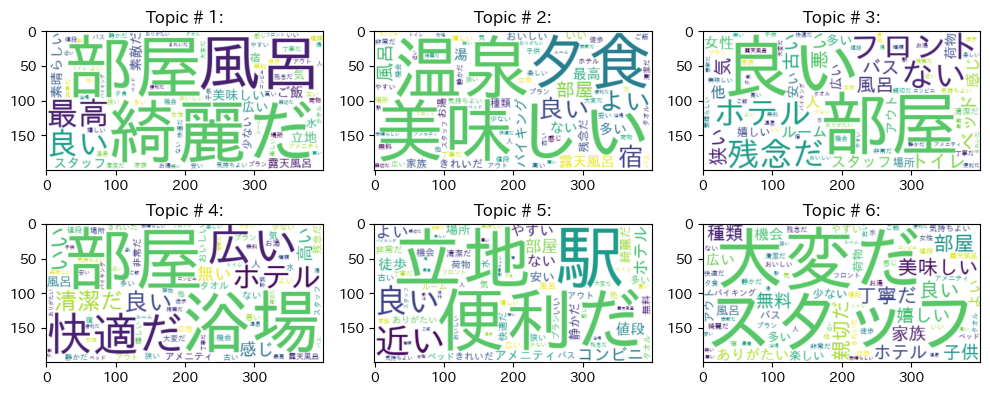

In [38]:
# トピックごとに出現確率Top 75語でワードクラウドを作成する
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

#### 1.10.3 トピック分布をプロットする

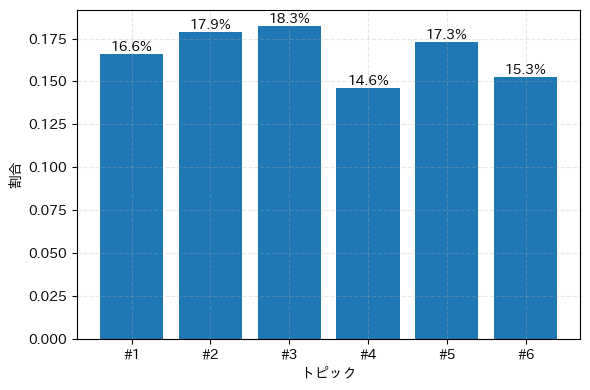

In [39]:
# 文書ごとのトピック比率を取得
doc_topic_distributions = lda.transform(cross_75_df.values)

# 文書全体のトピック比率を計算（平均を取る）
overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

gssm_utils.plot_topic_distribution(overall_topic_distribution)

---

### 1.11 外部変数の利用

#### 1.11.1 「文書-抽出語」表の作成

「文書-抽出語」表を作成する (出現回数 Top 150語)

In [40]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_150_df = pd.crosstab(
    [
        docs_150_df['カテゴリー'],
        docs_150_df['エリア'],
        docs_150_df['文書ID']
    ],
    docs_150_df['単語ID'], margins=False
)
cross_150_df.columns = word_counts_150_df["表層"]

# DataFrame を表示する
print(cross_150_df.shape)
display(cross_150_df)

(9750, 150)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  ごはん  \
カテゴリー  エリア   文書ID                                                ...        
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...    0   
             2       1   0    0   0     0   0   0     0   0   0  ...    0   
             3       1   4    1   0     0   1   1     1   0   0  ...    0   
             4       2   0    0   0     1   0   0     0   0   0  ...    0   
             5       0   1    1   0     0   0   0     0   0   0  ...    0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ...   
B_ビジネス 10_福岡 9996    0   2    0   0     0   0   0     0   0   0  ...    0   
             9997    0   0    0   0     0   0   0     0   1   0  ...    0   
             9998    1   1    0   0     0   0   0     3   0   0  ...    0   
             9999    1   1    1   2     0   1   0     0   0   0  ...    0   
             10000   2   0    1   1     0   0   0     0   0   0  ...    0   

表層                  小さい  事前  冷蔵庫  にくい  口コミ  内容  スペース  不満  周辺  
カテゴリー  エリア   文書ID                                             
A_レジャー 01_登別 1        0   0    0    0    0   0     0   0   0  
             2        0   0    0    0    0   0     0   0   0  
             3        0   0    0    0    0   0     0   0   0  
             4        0   0    0    0    0   0     0   0   0  
             5        0   0    0    0    0   0     0   0   0  
...                 ...  ..  ...  ...  ...  ..   ...  ..  ..  
B_ビジネス 10_福岡 9996     0   0    0    0    0   0     0   0   0  
             9997     0   0    0    0    0   0     0   0   0  
             9998     0   0    0    0    0   0     0   0   0  
             9999     0   0    0    0    0   0     0   0   0  
             10000    0   0    0    0    0   0     0   0   0  

[9750 rows x 150 columns]

「文書-抽出語」表を {0,1} に変換する

In [41]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_150_df[cross_150_df > 0] = 1

# DataFrame を表示する
print(cross_150_df.shape)
display(cross_150_df)

(9750, 150)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  ごはん  \
カテゴリー  エリア   文書ID                                                ...        
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...    0   
             2       1   0    0   0     0   0   0     0   0   0  ...    0   
             3       1   1    1   0     0   1   1     1   0   0  ...    0   
             4       1   0    0   0     1   0   0     0   0   0  ...    0   
             5       0   1    1   0     0   0   0     0   0   0  ...    0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ...   
B_ビジネス 10_福岡 9996    0   1    0   0     0   0   0     0   0   0  ...    0   
             9997    0   0    0   0     0   0   0     0   1   0  ...    0   
             9998    1   1    0   0     0   0   0     1   0   0  ...    0   
             9999    1   1    1   1     0   1   0     0   0   0  ...    0   
             10000   1   0    1   1     0   0   0     0   0   0  ...    0   

表層                  小さい  事前  冷蔵庫  にくい  口コミ  内容  スペース  不満  周辺  
カテゴリー  エリア   文書ID                                             
A_レジャー 01_登別 1        0   0    0    0    0   0     0   0   0  
             2        0   0    0    0    0   0     0   0   0  
             3        0   0    0    0    0   0     0   0   0  
             4        0   0    0    0    0   0     0   0   0  
             5        0   0    0    0    0   0     0   0   0  
...                 ...  ..  ...  ...  ...  ..   ...  ..  ..  
B_ビジネス 10_福岡 9996     0   0    0    0    0   0     0   0   0  
             9997     0   0    0    0    0   0     0   0   0  
             9998     0   0    0    0    0   0     0   0   0  
             9999     0   0    0    0    0   0     0   0   0  
             10000    0   0    0    0    0   0     0   0   0  

[9750 rows x 150 columns]

#### 1.11.2 共起行列を作成する (外部変数-抽出語)

In [42]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_df = pd.concat(
    [
        cross_150_df.groupby(level='カテゴリー').sum(),
        cross_150_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_df.shape)
display(aggregate_df)

(12, 150)


表層        部屋    良い   ホテル    風呂  美味しい   ない    温泉  スタッフ   立地   よい  ...  ごはん  \
A_レジャー  2325  2054   753  1474  1504  890  1292   856  550  648  ...   88   
B_ビジネス  2065  1649  1243   668   519  761   108   515  844  545  ...   81   
01_登別    435   398   157   301   269  185   267   118   57  109  ...   14   
02_草津    481   441   168   362   289  197   287   193  161  141  ...   18   
03_箱根    510   450   166   287   351  188   220   195   57  142  ...   17   
04_道後    380   366   218   190   202  150   257   103  164  136  ...   19   
05_湯布院   519   399    44   334   393  170   261   247  111  120  ...   20   
06_札幌    399   324   263   118   145  142    27   102  170  105  ...   20   
07_名古屋   388   334   243   147    95  161    26   125  145  115  ...   13   
08_東京    416   333   224   133    80  155    15    99  170   96  ...   15   
09_大阪    423   305   252   126    88  145    19    96  171  118  ...   14   
10_福岡    439   353   261   144   111  158    21    93  188  111  ...   19   

表層      小さい  事前  冷蔵庫  にくい  口コミ  内容  スペース  不満  周辺  
A_レジャー   93  95   82   80  102  99    63  66  63  
B_ビジネス   75  67   77   81   55  56    81  84  91  
01_登別    20  21   13    5   18  28    16  10   5  
02_草津    19  24   11   19   18  20    12  24  21  
03_箱根    23  22   26   16   30  16    19  10   8  
04_道後    15   6    7   19   13  15     8  12  15  
05_湯布院   16  22   25   21   23  20     8  10  14  
06_札幌    11  21    8   10    8   6    14  17  11  
07_名古屋   12  14   15   20   15  15    18  15  14  
08_東京    16  11   19   16   11   8    16  19  25  
09_大阪    19  14   23   21   10   9    15  18  22  
10_福岡    17   7   12   14   11  18    18  15  19  

[12 rows x 150 columns]

#### 1.11.3 Jaccard 係数を求める (外部変数-抽出語)

In [43]:
# 抽出語の出現回数を取得する
word_counts = cross_150_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('カテゴリー').values,
        all_df.value_counts('エリア').values
    ]
)

# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_attrs_df = gssm_utils.jaccard_attrs_coef(aggregate_df, attr_counts, word_counts, total=10000, conditional=False)

# DataFrame を表示する
print(jaccard_attrs_df.shape)
display(jaccard_attrs_df)

(12, 150)


表層            部屋        良い       ホテル        風呂      美味しい        ない        温泉  \
A_レジャー  0.329087  0.308919  0.000000  0.260056  0.272513  0.154487  0.252937   
B_ビジネス  0.000000  0.000000  0.216061  0.000000  0.000000  0.000000  0.000000   
01_登別   0.000000  0.092451  0.000000  0.105949  0.097676  0.075020  0.125176   
02_草津   0.097983  0.103473  0.000000  0.130216  0.105706  0.080277  0.135826   
03_箱根   0.104508  0.105808  0.000000  0.100525  0.131362  0.076330  0.100917   
04_道後   0.000000  0.000000  0.078474  0.000000  0.000000  0.000000  0.119925   
05_湯布院  0.106549  0.092704  0.000000  0.118946  0.149430  0.068521  0.122020   
06_札幌   0.000000  0.000000  0.096231  0.000000  0.000000  0.000000  0.000000   
07_名古屋  0.000000  0.000000  0.088267  0.000000  0.000000  0.000000  0.000000   
08_東京   0.000000  0.000000  0.080808  0.000000  0.000000  0.000000  0.000000   
09_大阪   0.000000  0.000000  0.091837  0.000000  0.000000  0.000000  0.000000   
10_福岡   0.000000  0.000000  0.095430  0.000000  0.000000  0.000000  0.000000   

表層          スタッフ        立地        よい  ...       ごはん       小さい        事前  \
A_レジャー  0.155213  0.000000  0.116862  ...  0.017319  0.018325  0.018749   
B_ビジネス  0.000000  0.152072  0.000000  ...  0.000000  0.000000  0.000000   
01_登別   0.000000  0.000000  0.000000  ...  0.000000  0.017422  0.018405   
02_草津   0.088613  0.072100  0.068713  ...  0.015639  0.016536  0.021090   
03_箱根   0.089614  0.000000  0.069235  ...  0.014757  0.020087  0.019298   
04_道後   0.000000  0.073543  0.066116  ...  0.016522  0.000000  0.000000   
05_湯布院  0.116290  0.000000  0.057887  ...  0.017406  0.000000  0.019298   
06_札幌   0.000000  0.076439  0.000000  ...  0.017406  0.000000  0.018405   
07_名古屋  0.000000  0.064473  0.000000  ...  0.000000  0.000000  0.000000   
08_東京   0.000000  0.076439  0.000000  ...  0.000000  0.000000  0.000000   
09_大阪   0.000000  0.076923  0.000000  ...  0.000000  0.016536  0.000000   
10_福岡   0.000000  0.085222  0.000000  ...  0.016522  0.014770  0.000000   

表層           冷蔵庫       にくい       口コミ        内容      スペース        不満        周辺  
A_レジャー  0.016151  0.000000  0.020178  0.019581  0.000000  0.000000  0.000000  
B_ビジネス  0.000000  0.015945  0.000000  0.000000  0.015998  0.016581  0.017974  
01_登別   0.000000  0.000000  0.015803  0.024845  0.014184  0.000000  0.000000  
02_草津   0.000000  0.016637  0.015803  0.017621  0.000000  0.021314  0.018535  
03_箱根   0.022948  0.000000  0.026619  0.014047  0.016889  0.000000  0.000000  
04_道後   0.000000  0.016637  0.000000  0.000000  0.000000  0.000000  0.000000  
05_湯布院  0.022046  0.018421  0.020282  0.017621  0.000000  0.000000  0.000000  
06_札幌   0.000000  0.000000  0.000000  0.000000  0.000000  0.015004  0.000000  
07_名古屋  0.000000  0.017528  0.000000  0.000000  0.015986  0.000000  0.000000  
08_東京   0.016667  0.000000  0.000000  0.000000  0.014184  0.016799  0.022143  
09_大阪   0.020246  0.018421  0.000000  0.000000  0.013286  0.015901  0.019435  
10_福岡   0.000000  0.000000  0.000000  0.015831  0.015986  0.000000  0.016740  

[12 rows x 150 columns]

#### 1.11.4 特徴語ランキング

In [44]:
# 「カテゴリ」や「エリア」ごとに Jaccard 係数のTop 10語を抽出する
df_list = []
for index, row in jaccard_attrs_df.iterrows():
    df_list.append(row.iloc[np.argsort(row.values)[::-1][:10]].reset_index())

# 「カテゴリ」や「エリア」ごとの Jaccard 係数のTop 10 を横方向に連結した DetaFrame を作成する
ranking_df = pd.DataFrame(pd.concat(df_list, axis=1))
ranking_df.columns = np.array([c for pair in [[x,f"jaccard"] for x in jaccard_attrs_df.index] for c in pair], dtype='object')

# DataFrame を表示する
display(ranking_df)

A_レジャー   jaccard B_ビジネス   jaccard 01_登別   jaccard 02_草津   jaccard 03_箱根  \
0     部屋  0.329087    ホテル  0.216061    温泉  0.125176    温泉  0.135826  露天風呂   
1     良い  0.308919      駅  0.152966    風呂  0.105949    風呂  0.130216  美味しい   
2   美味しい  0.272513     立地  0.152072  美味しい  0.097676     宿  0.111179    良い   
3     風呂  0.260056    便利だ  0.142236    良い  0.092451  美味しい  0.105706    部屋   
4     温泉  0.252937     近い  0.107584    夕食  0.085120    良い  0.103473    温泉   
5   スタッフ  0.155213   フロント  0.104562   残念だ  0.080441    部屋  0.097983    風呂   
6     ない  0.154487    綺麗だ  0.102536    種類  0.080087  スタッフ  0.088613    夕食   
7      宿  0.147732    快適だ  0.093102    ない  0.075020     湯  0.086039     宿   
8   露天風呂  0.144698   コンビニ  0.087271    多い  0.074556    最高  0.084148  スタッフ   
9     最高  0.131296  アメニティ  0.073719  露天風呂  0.073805    バス  0.080656   大変だ   

    jaccard  ... 06_札幌   jaccard 07_名古屋   jaccard  08_東京   jaccard 09_大阪  \
0  0.137092  ...   ホテル  0.096231    ホテル  0.088267      駅  0.122837     駅   
1  0.131362  ...   便利だ  0.083069      駅  0.070368     近い  0.082988   ホテル   
2  0.105808  ...    立地  0.076439    便利だ  0.069488    便利だ  0.081924   便利だ   
3  0.104508  ...    浴場  0.070343     立地  0.064473   コンビニ  0.081323    立地   
4  0.100917  ...     駅  0.069780   フロント  0.063806    ホテル  0.080808    近い   
5  0.100525  ...   快適だ  0.062574  アメニティ  0.061292     立地  0.076439  コンビニ   
6  0.097240  ...   綺麗だ  0.061578    綺麗だ  0.059421   フロント  0.061408  フロント   
7  0.091182  ...    広い  0.059018    快適だ  0.055100  アメニティ  0.056366   快適だ   
8  0.089614  ...  フロント  0.058427     近い  0.054850    快適だ  0.054482    広い   
9  0.085714  ...  コンビニ  0.054435   コンビニ  0.047397    やすい  0.051525   綺麗だ   

    jaccard  10_福岡   jaccard  
0  0.099379    ホテル  0.095430  
1  0.091837     立地  0.085222  
2  0.080211    便利だ  0.082496  
3  0.076923      駅  0.080466  
4  0.074706     近い  0.065928  
5  0.068801   フロント  0.065611  
6  0.065008    快適だ  0.055718  
7  0.062574   コンビニ  0.050904  
8  0.062530  アメニティ  0.050792  
9  0.059421    ベッド  0.044886  

[10 rows x 24 columns]

#### 1.11.5 ワードクラウド (カテゴリーごと)

A_レジャー


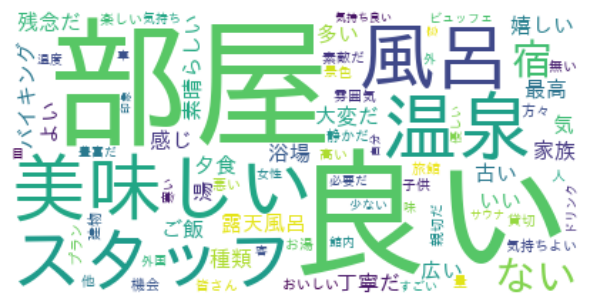

B_ビジネス


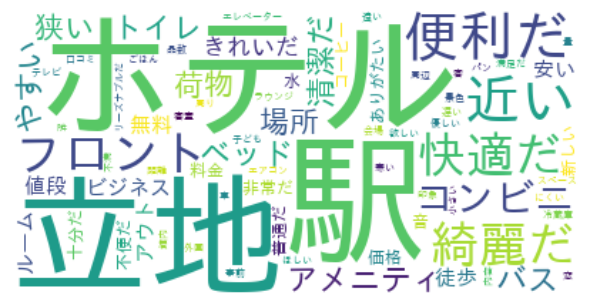

In [45]:
for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # プロットする
    gssm_utils.plot_wordcloud(" ".join(group_cross_df.columns))

#### 1.11.6 共起ネットワーク図 (カテゴリーごと)

A_レジャー


<Figure size 800x800 with 0 Axes>

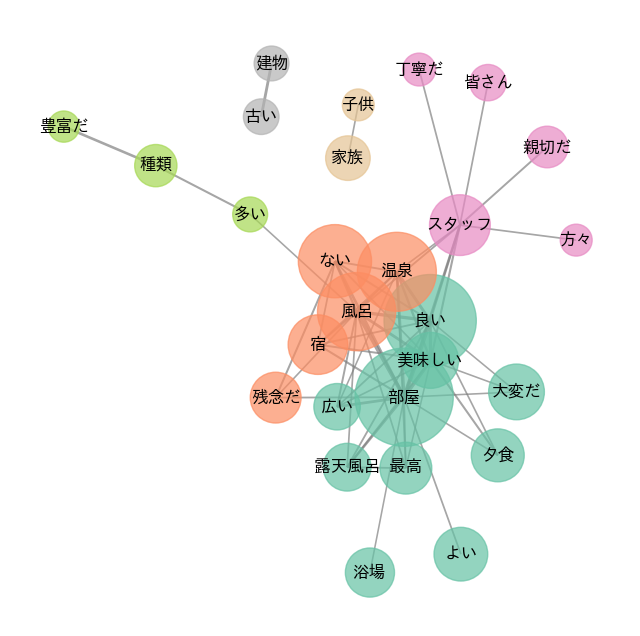

B_ビジネス


<Figure size 800x800 with 0 Axes>

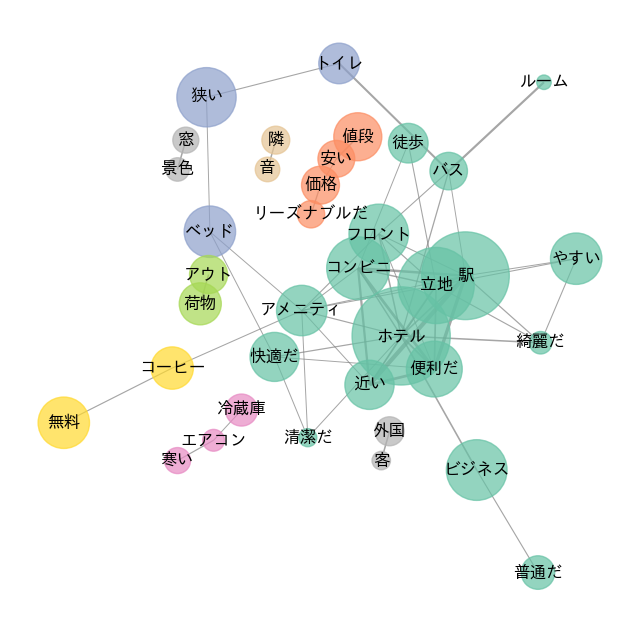

In [46]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = gssm_utils.jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group.sum(axis=0).values

    # プロットする
    gssm_utils.plot_cooccur_network(group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][60])

#### 1.11.7 トピック分布 (カテゴリーごと)

#### 1.11.7.1 文書全体からトピックを抽出する (LDA)

In [47]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=42, n_jobs=-1, n_components=6)
lda.fit(cross_150_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_150_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

Topic # 1: 美味しい 最高 温泉 良い 夕食 露天風呂 宿 部屋 風呂 ご飯 大変だ バイキング 家族 量 多い いい 機会 素晴らしい 無料 品数 
Topic # 2: 良い ない 残念だ 部屋 風呂 浴場 多い 悪い 種類 ホテル 温泉 他 サウナ ビュッフェ 豊富だ 温度 人 寒い 客 高い 
Topic # 3: 便利だ 駅 ホテル 良い 近い 立地 部屋 コンビニ ない 安い バス 徒歩 ビジネス ルーム 価格 アメニティ 値段 フロント やすい 場所 
Topic # 4: 部屋 よい 広い 快適だ 清潔だ きれいだ 浴場 おいしい 風呂 非常だ 良い ホテル 十分だ 立地 ない 新しい 気持ちよい エレベーター 建物 にくい 
Topic # 5: 部屋 風呂 綺麗だ 良い 広い トイレ ない 気 アメニティ やすい 立地 嬉しい 狭い 静かだ 残念だ 貸切 よい 水 美味しい すごい 
Topic # 6: スタッフ 丁寧だ フロント 良い 親切だ 部屋 気持ちよい 素晴らしい 方々 ホテル 皆さん 素敵だ 感じ 温泉 笑顔 優しい 大変だ 宿 気持ち 女性 


#### 1.11.7.2 トピックをワードクラウドで描画する

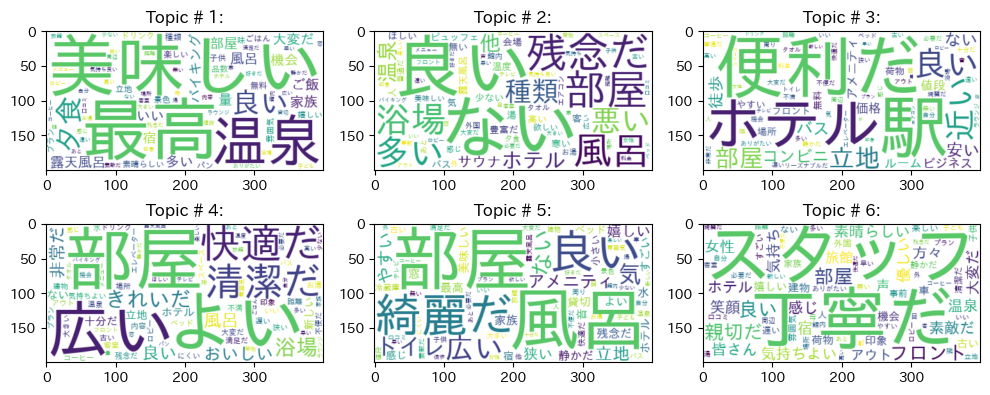

In [48]:
# トピックごとに出現確率Top 75語でワードクラウドを作成する
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

#### 1.11.7.3 トピック分布をプロットする

A_レジャー


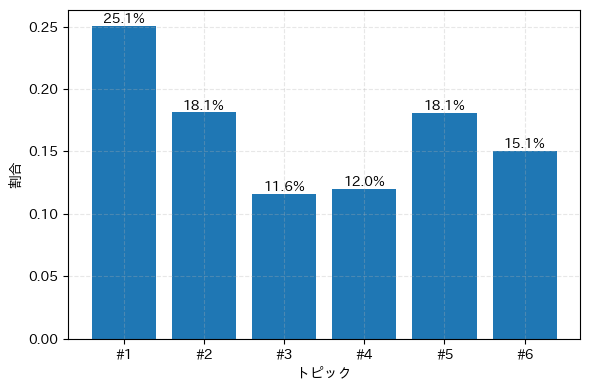

B_ビジネス


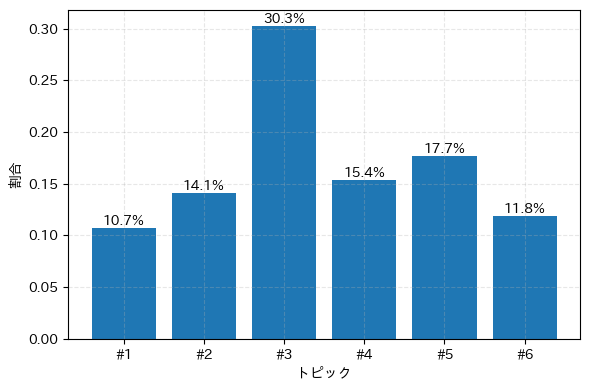

In [49]:
for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 文書ごとのトピック比率を取得
    doc_topic_distributions = lda.transform(group.values)

    # 文書全体のトピック比率を計算（平均を取る）
    overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

    gssm_utils.plot_topic_distribution(overall_topic_distribution)

#### 1.11.8 本文の参照 (カテゴリーごと)

「夕食」「残念」という単語が含まれている口コミを表示する

In [50]:
for name, group in all_df.groupby('カテゴリー'):
    print(name)
    search_index = group['コメント'].str.contains('夕食') & group['コメント'].str.contains('残念')
    display(group[search_index])

A_レジャー


カテゴリー     エリア    施設番号             施設名  \
16    A_レジャー   01_登別   39175  登別温泉　登別グランドホテル   
23    A_レジャー   01_登別   40708   虎杖浜温泉　ホテル　いずみ   
32    A_レジャー   01_登別   28637      登別温泉　登別万世閣   
65    A_レジャー   01_登別   18832    きたゆざわ　森のソラニワ   
93    A_レジャー   01_登別   40708   虎杖浜温泉　ホテル　いずみ   
...      ...     ...     ...             ...   
4875  A_レジャー  05_湯布院  180079         由布院　玉の湯   
4883  A_レジャー  05_湯布院  184560          由布院倶楽部   
4934  A_レジャー  05_湯布院   72793      由布院温泉　楓の小舎   
4942  A_レジャー  05_湯布院  184593    由布院　離れの宿　優夏月   
4944  A_レジャー  05_湯布院    1678   由布院温泉　ゆふいん山水館   

                                                   コメント  総合  サービス  立地  部屋  \
16    ４月１２日に宿泊しました。記念日に近かったので普段選ばない露天風呂付客室を選びましたが、部屋...   5     4   4   5   
23    両親と3世代の温泉旅行にこの宿を選びました。部屋の、古さはありましたが、部屋の暖房も良く、清...   5     4   4   3   
32    シャンプーが色々な種類があって選べて最高でした。ご時世もあり海外の方が多く、温泉にバスタオル...   4     4   4   2   
65    夏場なら札幌から車で1:30ほどで到着でき、洞爺湖やルスツにも足を伸ばせる立地。人手不足なの...   3     3   5   1   
93    食事は朝食も夕食も、食べきれないくらいのボリューム！どれも美味しかったですし、スタッフの皆さ...   4     4   5   4   
...                                                 ...  ..   ...  ..  ..   
4875  12年ぶりの宿泊とチェックイン時に教えてくれるメールで確認事項を送ってあったようだけどPCの...   4     4   5   4   
4883  夕食は美味しかったが、朝食のビュッフェが客動線が悪くて待ち時間が長かったのが残念だった。フロ...   3     5   3   3   
4934  こちらの口コミは参考になりませんでした。夕食：お刺身が臭った。予約時プラン内容説明時点でのお...   2     3   4   2   
4942  11月24日　家族4人で宿泊しました。　久しぶりの家族旅行でとても楽しみにしていた旅行です。...   3     4   4   3   
4944  12/1に宿泊しました。オールインクルーシブを楽しみにして、湯布院の宿の中から本旅館にしまし...   4     4   4   4   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月           投稿者   年代  性別           投稿日  
16         4.0  5.0  5.0  レジャー  家族  45383           投稿者   na  na  45400.395394  
23         5.0  4.0  4.0  レジャー  一人  45748          カリばば  60代  女性  45778.405301  
32         5.0  5.0  5.0  レジャー  家族  45748           投稿者   na  na  45775.668414  
65         3.0  5.0  4.0  レジャー  家族  45474    hedwig6284  70代  男性  45488.557685  
93         2.0  4.0  5.0  レジャー  家族  45536           投稿者   na  na  45557.507164  
...        ...  ...  ...   ...  ..    ...           ...  ...  ..           ...  
4875       4.0  4.0  4.0  レジャー  家族  45413           投稿者   na  na  45454.865984  
4883       4.0  3.0  2.0  レジャー  家族  45627           投稿者   na  na  45659.789306  
4934       3.0  3.0  1.0  レジャー  家族  45505  meru20220811  40代  男性  45518.586725  
4942       4.0  3.0  3.0  レジャー  家族  45597           投稿者   na  na  45623.930984  
4944       3.0  4.0  4.0  レジャー  家族  45627           投稿者   na  na  45632.704907  

[111 rows x 19 columns]

B_ビジネス


カテゴリー    エリア    施設番号                    施設名  \
5188  B_ビジネス  06_札幌  184541          ウィンダムガーデン札幌大通   
5959  B_ビジネス  06_札幌   27895         アパホテル＆リゾート〈札幌〉   
9627  B_ビジネス  10_福岡  180283            Ｔｈｅ３５８　ＳＯＲＡ   
9631  B_ビジネス  10_福岡  187154  Ａｌｂａ　ＨＯＴＥＬ　＆　Ｇｌａｍｐｉｎｇ   
9703  B_ビジネス  10_福岡  179190      ガーデンテラス福岡ホテル＆リゾート   
9916  B_ビジネス  10_福岡  180283            Ｔｈｅ３５８　ＳＯＲＡ   

                                                   コメント  総合  サービス  立地  部屋  \
5188  飛行機の大幅な遅延のため、予定より４時間チュックインが遅れました。ワンドリンクでアルコールが...   4     4   4   4   
5959  札幌の街より少し郊外ですが、駐車場も無料なので車で行くには丁度良かったです。部屋も広く子ども...   5     5   4   5   
9627  子供の誕生日ということもあり、初めて夕食付きのプランで数ヵ月前から予約してました。行く前から...   3     3   3   4   
9631  インスタで見つけてスカイルームのお部屋を予約しました。まず受付で食事などの説明はありましたが...   3     2   4   4   
9703  夕食、朝食ともに部屋着のまま、のんびり頂きました。1階のラウンジは、飲み物の種類もたくさんあ...   5     5   5   5   
9916  夕食はカニが食べたくて、少し金額の高い「カニ食べ放題」のあるプランにしましたが、ブッフェだっ...   4     5   5   4   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月     投稿者   年代  性別           投稿日  
5188       3.0  3.0  NaN  レジャー  友達  45717     投稿者   na  na  45753.671609  
5959       5.0  4.0  4.0  レジャー  家族  45658     投稿者   na  na  45682.764120  
9627       4.0  NaN  4.0  レジャー  家族  45689     投稿者   na  na  45700.565995  
9631       1.0  1.0  4.0  レジャー  一人  45505     投稿者   na  na  45530.491667  
9703       5.0  5.0  5.0  レジャー  家族  45444     投稿者   na  na  45447.790671  
9916       4.0  5.0  5.0  レジャー  家族  45748  moppyi  60代  女性  45766.753113

In [51]:
for name, group in all_df.groupby('カテゴリー'):
    print(name)
    search_index = group['コメント'].str.contains('夕食') & group['コメント'].str.contains('残念')
    print(group[search_index]['コメント'].values[:10])  # とりあえず10件のみ出力
    print()

A_レジャー
['４月１２日に宿泊しました。記念日に近かったので普段選ばない露天風呂付客室を選びましたが、部屋そのものが広くてゆったりとくつろげました。露天風呂がしっかり分かれていたため湿気の入り込みもなく、人工温泉でもしっかりと温まりました。インバウンドの方が増えてきたため込み合う時間は部屋の風呂、空いている時間は大浴場と使い分けして快適に過ごせました。ご飯も美味しく、夕食のビーフシチュー、朝食の鶏ご飯が好みでした。残念だったのは、ゲームコーナーが故障機種が多かったことくらいですね。普通のお部屋でも十分満足できますが、特別な日に空きがあったらまた利用したいと思います。'
 '両親と3世代の温泉旅行にこの宿を選びました。部屋の、古さはありましたが、部屋の暖房も良く、清潔感もありました。ただ、日曜日で日帰りのお客様が多いため、両親はゆっくり風呂には入れなかったようです。夕食は、残さず食べましたが、朝食に白老か近いのに、卵料理がないのは残念でした。また、朝食にパンなど選ぶことができたら、良かったと思います。トロトロの最高のお湯質なのに、ゆっくり入ることができないのは、残念した。'
 'シャンプーが色々な種類があって選べて最高でした。ご時世もあり海外の方が多く、温泉にバスタオルを巻いて入っていたりしていたので少し残念でした。お部屋は和室にしましたが、古いお部屋だったようでかなり寒かったです。お部屋の角にホコリが溜まっていたりして残念でした。夕食も朝食もバイキングにしましたがお食事は満足です。子供たちも好きなものを好きなだけ食べて満足していました。'
 '夏場なら札幌から車で1:30ほどで到着でき、洞爺湖やルスツにも足を伸ばせる立地。人手不足なのかレセプションは対面1名のスタッフと、自動チェックイン機が2台のみで、15時は大変混雑するため、夕飯の時間をこだわりたいなら30分前から並ぶ方が良い。地下のプレイパークはチェックイン前から遊べるのが嬉しい。内容は未就学児向けにできていて、体力発散できてとても良い。大浴場も広くて混雑を感じにくい作り。客室は掃除が行き届いておらず、ゴミや髪の毛がかなり落ちていて残念。ソファーの座面パーツが何故か無く、スタッフに持ってきていただいた。これはテンションが下がる…。上の階の足音もかなり響く。20時過ぎても館内放送がかかり騒がしい。夕食のビュッ

---

## 【演習】 外部変数を利用したエリアごとの作図

注意: 以下の演習は上のセルを全て実行してから続けて実施してください

#### 2.1 【演習】 ワードクラウド (エリアごと)

01_登別


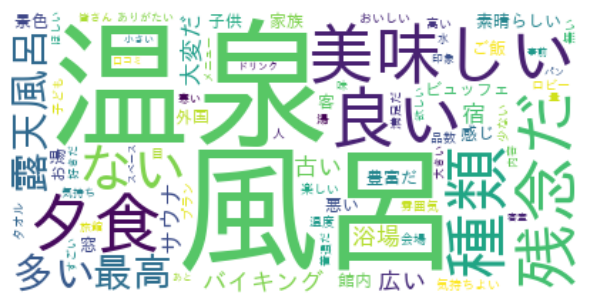

02_草津


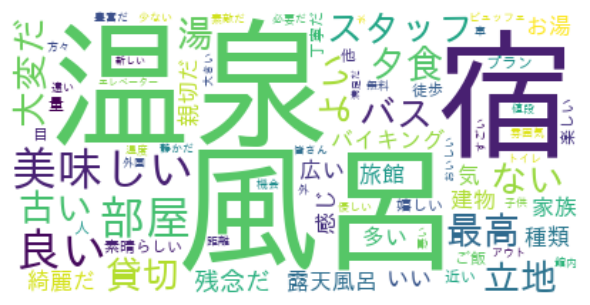

03_箱根


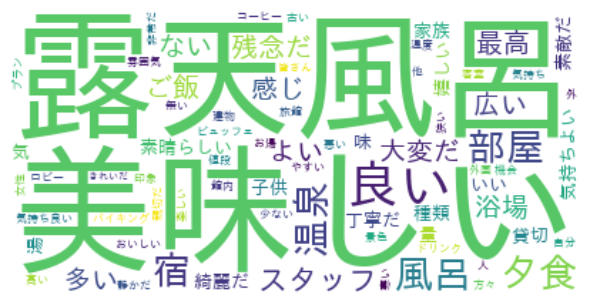

04_道後


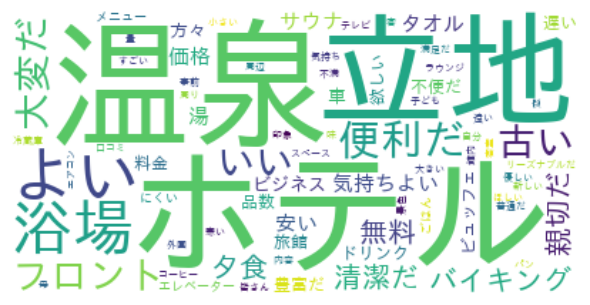

05_湯布院


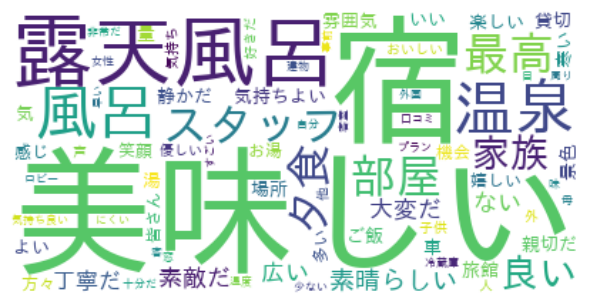

06_札幌


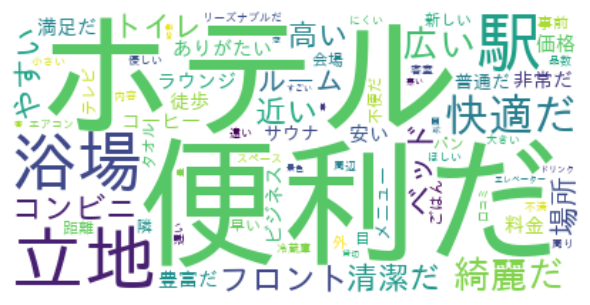

07_名古屋


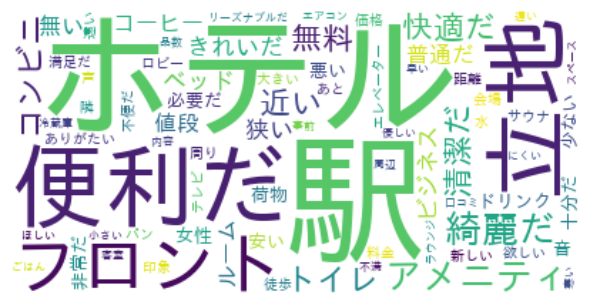

08_東京


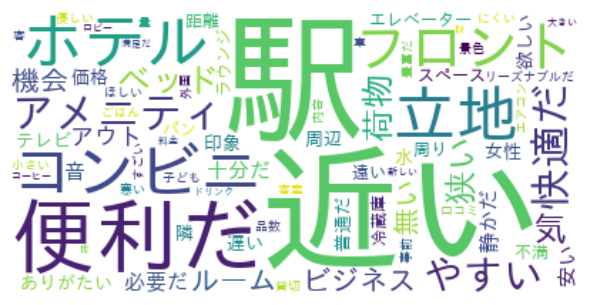

09_大阪


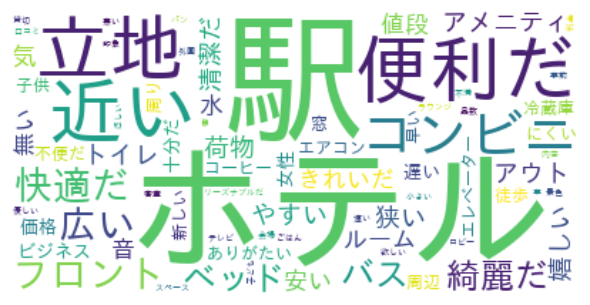

10_福岡


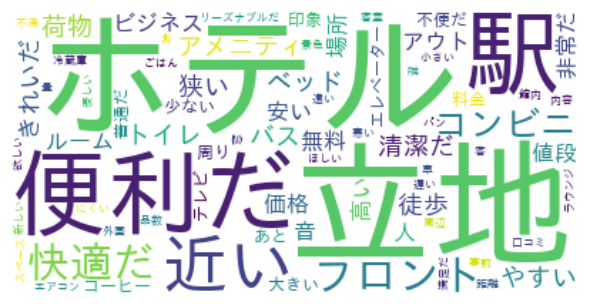

In [52]:
# ToDo: 1.11.5 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

for name, group in cross_150_df.groupby(level='エリア'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # プロットする
    gssm_utils.plot_wordcloud(" ".join(group_cross_df.columns))

#### 2.2 【演習】 共起ネットワーク図 (エリアごと)

01_登別


<Figure size 800x800 with 0 Axes>

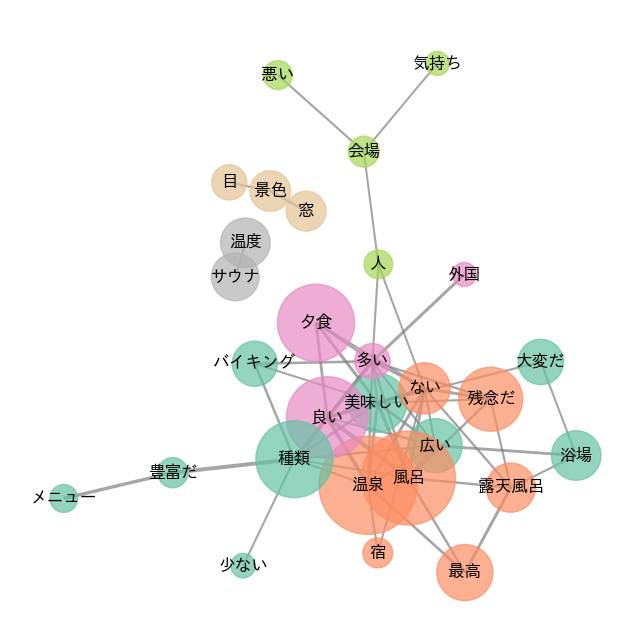

02_草津


<Figure size 800x800 with 0 Axes>

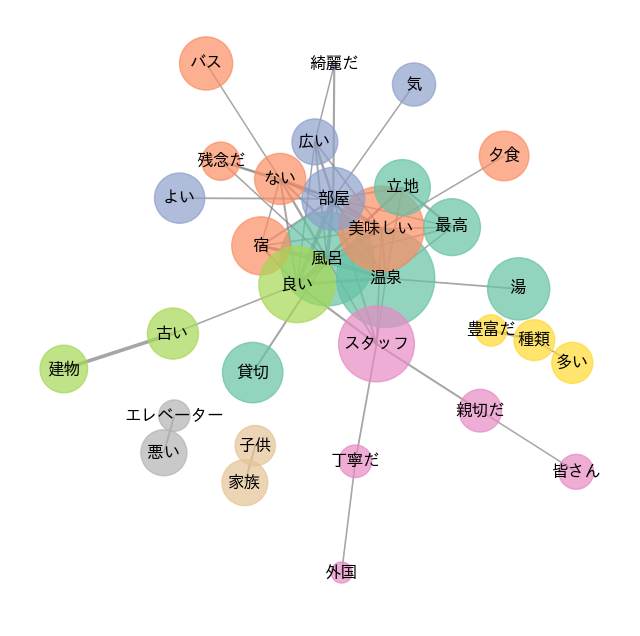

03_箱根


<Figure size 800x800 with 0 Axes>

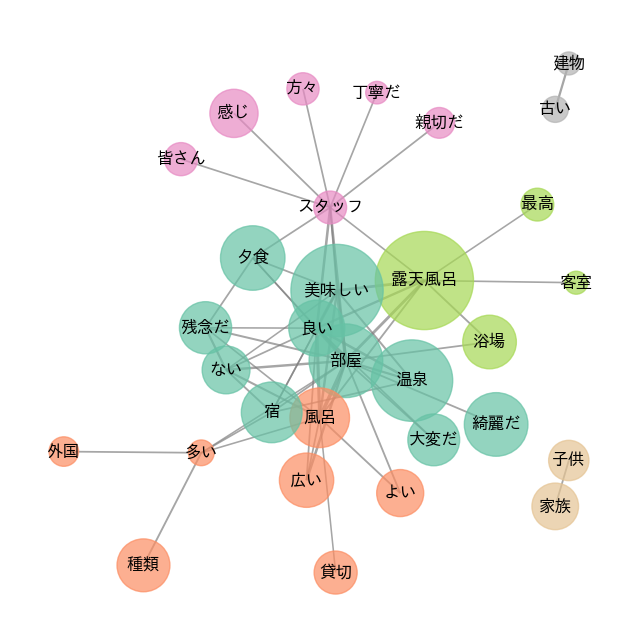

04_道後


<Figure size 800x800 with 0 Axes>

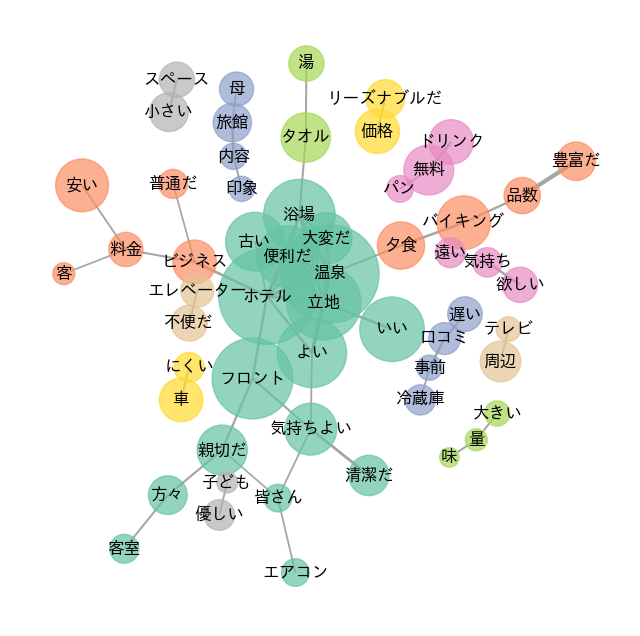

05_湯布院


<Figure size 800x800 with 0 Axes>

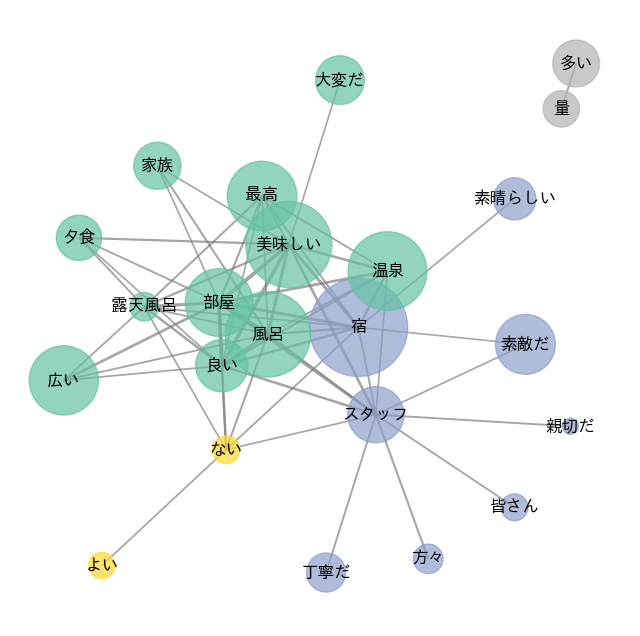

06_札幌


<Figure size 800x800 with 0 Axes>

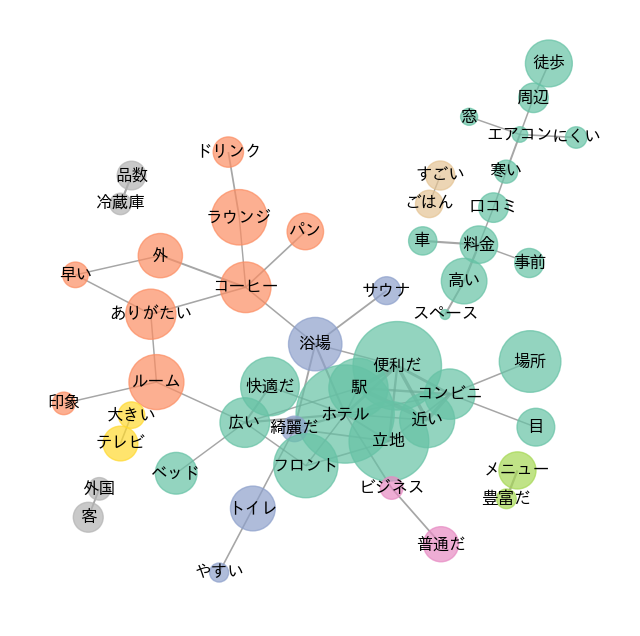

07_名古屋


<Figure size 800x800 with 0 Axes>

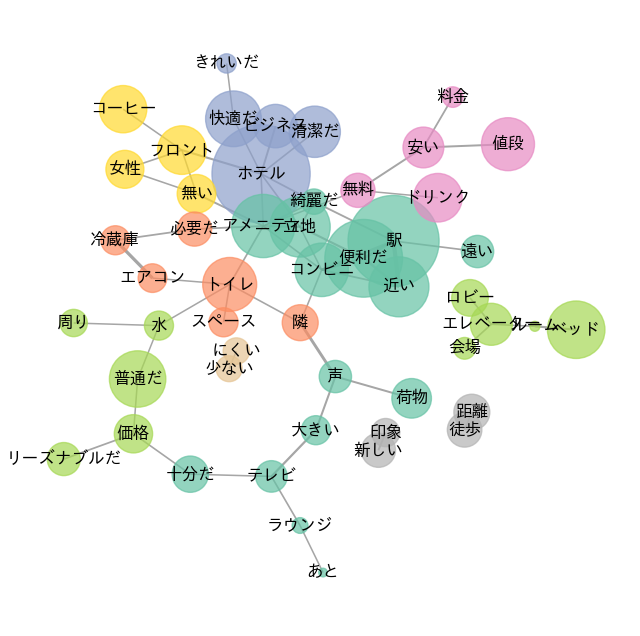

08_東京


<Figure size 800x800 with 0 Axes>

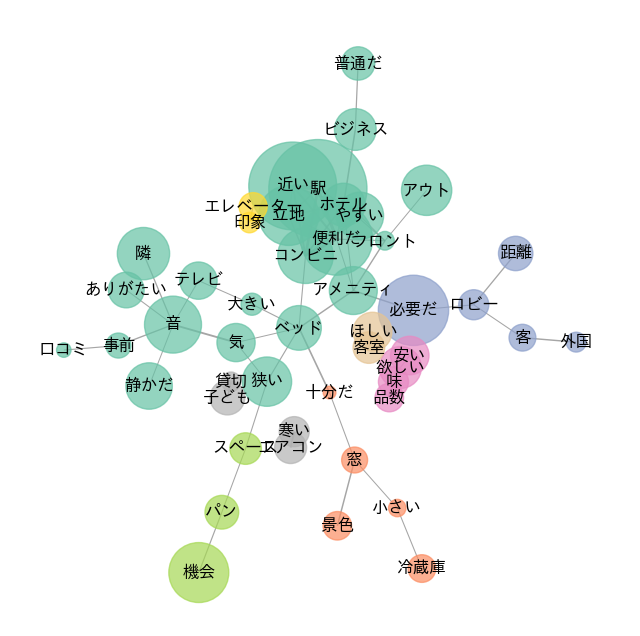

09_大阪


<Figure size 800x800 with 0 Axes>

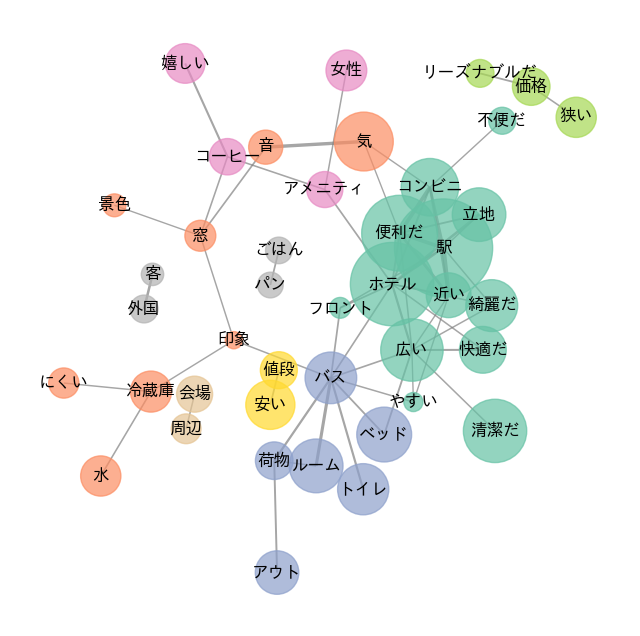

10_福岡


<Figure size 800x800 with 0 Axes>

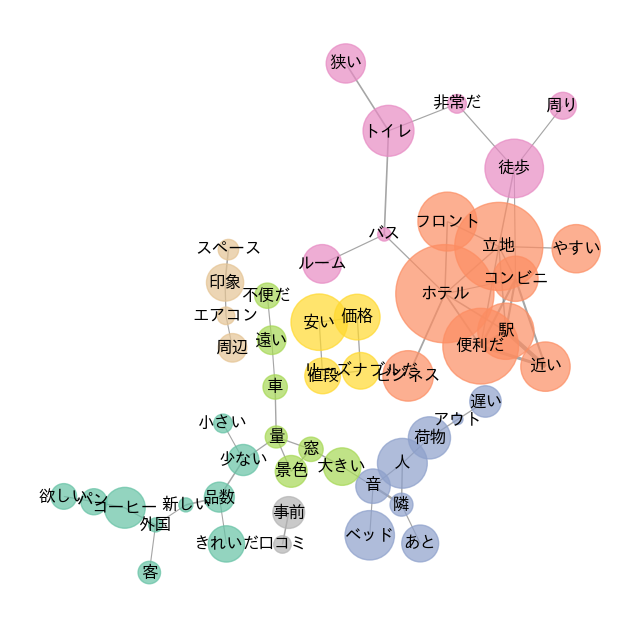

In [53]:
# ToDo: 1.11.6 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

for name, group in cross_150_df.groupby(level='エリア'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = gssm_utils.jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group.sum(axis=0).values

    # プロットする
    gssm_utils.plot_cooccur_network(group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][60])

#### 2.3 【演習】 トピック分布 (エリアごと)

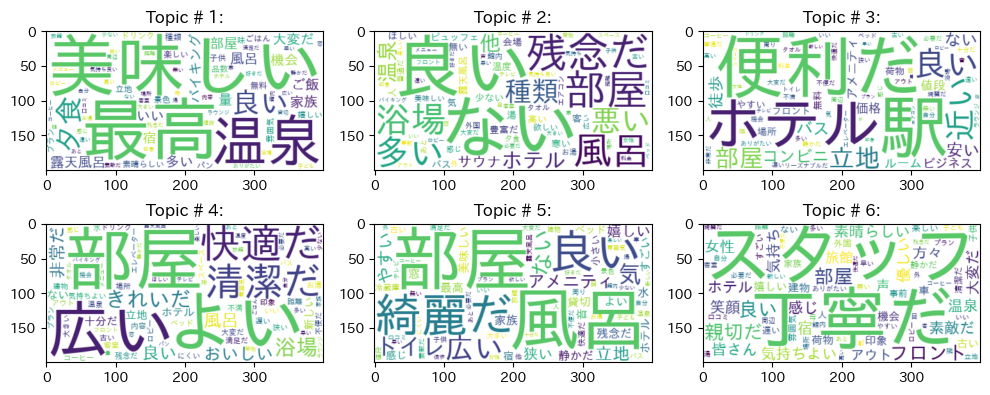

In [54]:
# ToDo: 1.11.7.2 のセル中のコードをコピーして貼り付け,そのまま実行する

n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

01_登別


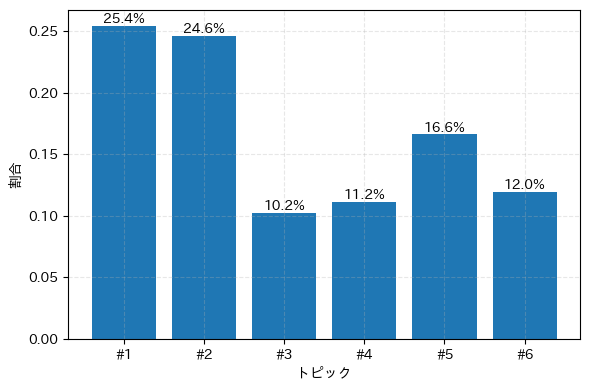

02_草津


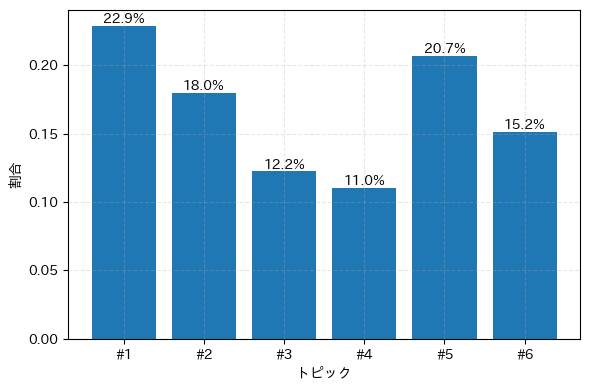

03_箱根


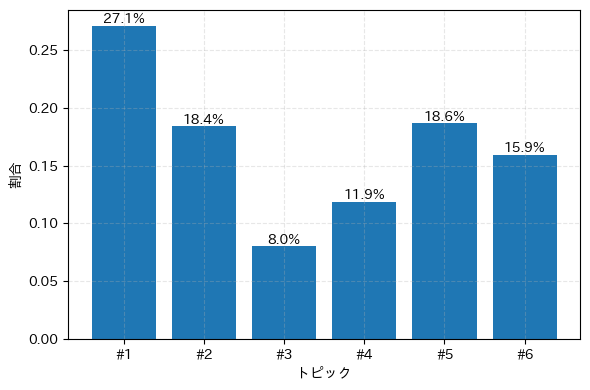

04_道後


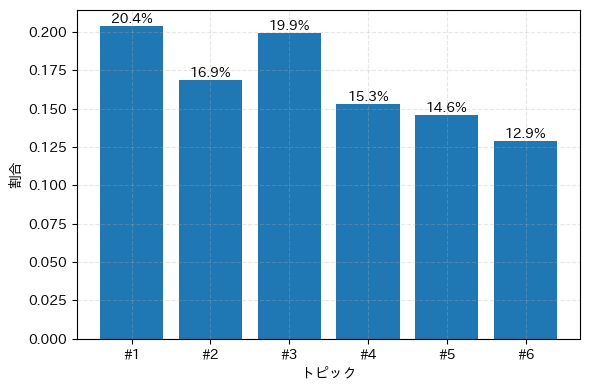

05_湯布院


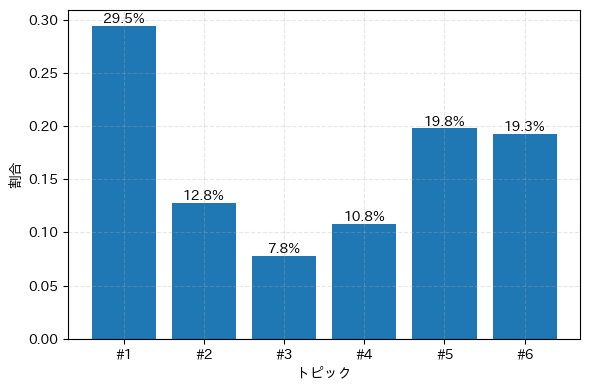

06_札幌


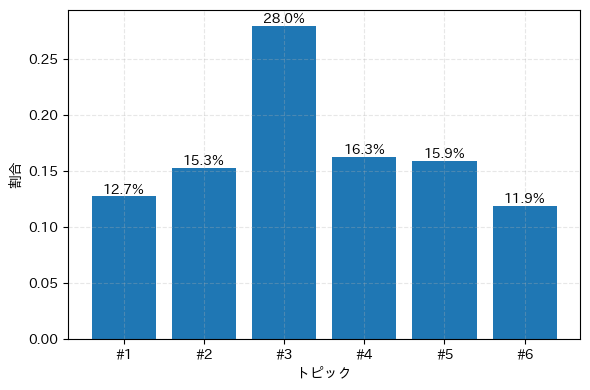

07_名古屋


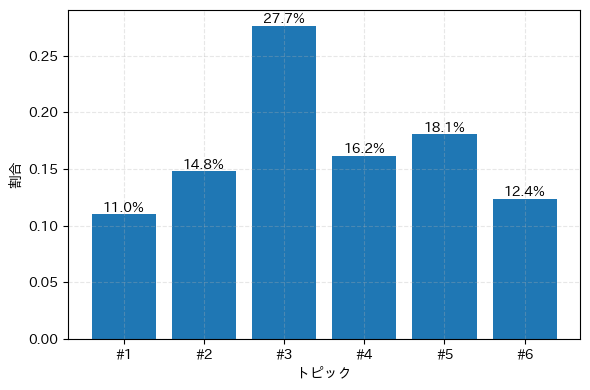

08_東京


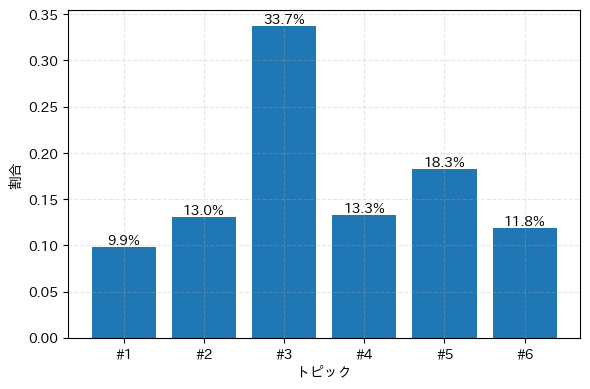

09_大阪


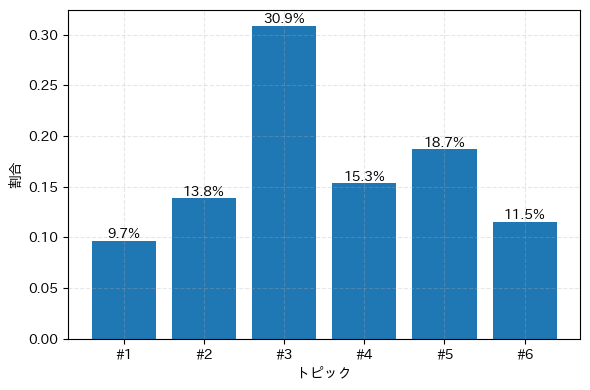

10_福岡


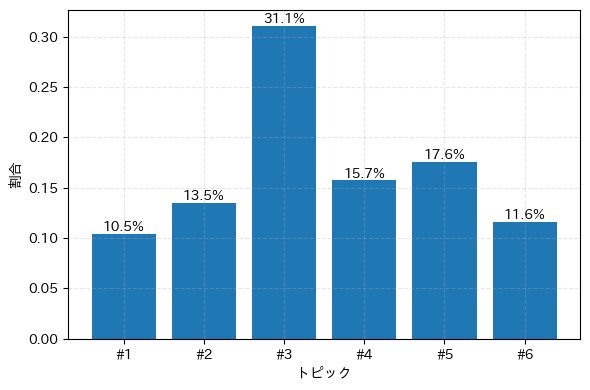

In [55]:
# ToDo: 1.11.7.3 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

for name, group in cross_150_df.groupby(level='エリア'):
    print(name)

    # 文書ごとのトピック比率を取得
    doc_topic_distributions = lda.transform(group.values)

    # 文書全体のトピック比率を計算（平均を取る）
    overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

    gssm_utils.plot_topic_distribution(overall_topic_distribution)

#### 2.4 【演習】 本文の参照 (エリアごと)

In [56]:
# ToDo: 1.11.8 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

for name, group in all_df.groupby('エリア'):
    print(name)
    search_index = group['コメント'].str.contains('夕食') & group['コメント'].str.contains('残念')
    display(group[search_index].head())  # 先頭の5件ずつ表示

01_登別


カテゴリー    エリア   施設番号             施設名  \
16  A_レジャー  01_登別  39175  登別温泉　登別グランドホテル   
23  A_レジャー  01_登別  40708   虎杖浜温泉　ホテル　いずみ   
32  A_レジャー  01_登別  28637      登別温泉　登別万世閣   
65  A_レジャー  01_登別  18832    きたゆざわ　森のソラニワ   
93  A_レジャー  01_登別  40708   虎杖浜温泉　ホテル　いずみ   

                                                 コメント  総合  サービス  立地  部屋  \
16  ４月１２日に宿泊しました。記念日に近かったので普段選ばない露天風呂付客室を選びましたが、部屋...   5     4   4   5   
23  両親と3世代の温泉旅行にこの宿を選びました。部屋の、古さはありましたが、部屋の暖房も良く、清...   5     4   4   3   
32  シャンプーが色々な種類があって選べて最高でした。ご時世もあり海外の方が多く、温泉にバスタオル...   4     4   4   2   
65  夏場なら札幌から車で1:30ほどで到着でき、洞爺湖やルスツにも足を伸ばせる立地。人手不足なの...   3     3   5   1   
93  食事は朝食も夕食も、食べきれないくらいのボリューム！どれも美味しかったですし、スタッフの皆さ...   4     4   5   4   

    設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月         投稿者   年代  性別           投稿日  
16       4.0  5.0  5.0  レジャー  家族  45383         投稿者   na  na  45400.395394  
23       5.0  4.0  4.0  レジャー  一人  45748        カリばば  60代  女性  45778.405301  
32       5.0  5.0  5.0  レジャー  家族  45748         投稿者   na  na  45775.668414  
65       3.0  5.0  4.0  レジャー  家族  45474  hedwig6284  70代  男性  45488.557685  
93       2.0  4.0  5.0  レジャー  家族  45536         投稿者   na  na  45557.507164

02_草津


カテゴリー    エリア    施設番号            施設名  \
1054  A_レジャー  02_草津    5270  草津温泉　ホテルヴィレッジ   
1154  A_レジャー  02_草津  129576       草津温泉　大東舘   
1349  A_レジャー  02_草津   17837   草津温泉　喜びの宿　高松   
1372  A_レジャー  02_草津    5270  草津温泉　ホテルヴィレッジ   
1392  A_レジャー  02_草津    4904        草津温泉　望雲   

                                                   コメント  総合  サービス  立地  部屋  \
1054  基本的には満足です。数点残念な点がありました。夕食のバイキングにて20時入店ステーキの焼き立...   4     3   4   2   
1154  夕食、朝食とも品数があり申し分なし。アルコールが別料金、温泉は思っていたほど臭いがなく残念。...   4     3   5   4   
1349  夕食も朝食もとてもおいしかったです。部屋についている冷蔵庫が特殊だったのが少し残念でしたが、...   5     5   5   5   
1372  お風呂と食事が気に入り2回目の宿泊です。前回よりも食事については良かったと思います。夕食の野...   4     3   3   3   
1392  現在リニューアル工事中でしたが、工事が終わっている部分はとてもきれいでよかったです。玄関と回...   4     5   4   5   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月       投稿者   年代  性別           投稿日  
1054       2.0  4.0  4.0  レジャー  家族  45658       投稿者   na  na  45680.813067  
1154       4.0  4.0  5.0  レジャー  一人  45748   はづき1971  50代  男性  45767.665093  
1349       4.0  5.0  5.0  レジャー  恋人  45658       投稿者   na  na  45671.391505  
1372       3.0  4.0  4.0  レジャー  家族  45748  もっさり6996  50代  男性  45756.431262  
1392       4.0  5.0  5.0  レジャー  家族  45536       投稿者   na  na  45562.791157

03_箱根


カテゴリー    エリア    施設番号                                  施設名  \
2024  A_レジャー  03_箱根   11011              富士山を一望できる宿　ホテルグリーンプラザ箱根   
2026  A_レジャー  03_箱根    1727                               富士屋ホテル   
2039  A_レジャー  03_箱根  153202                    小塚久の葉（旧　箱根仙石原虎乃湯）   
2047  A_レジャー  03_箱根   15250  ＥＮ　ＲＥＳＯＲＴ　Ｒｅ’Ｃｏｖｅ　Ｈａｋｏｎｅ（旧：リ・カーヴ箱根）   
2086  A_レジャー  03_箱根    5081                      箱根湯本温泉　ホテルおくゆもと   

                                                   コメント  総合  サービス  立地  部屋  \
2024  夕食のビュッフェの質が悪く、写真と違いすぎて食べられませんでした。非常に残念で、旅行の気分に...   2     4   4   3   
2026  建物が素晴らしいです。スタッフの方々のご対応も素晴らしいのですが、１つ残念なことがありました...   4     4   5   4   
2039  全体的にコスパ含め、満足。こじんまりした宿で静か。子ども連れや外国人をいたが、音は聞こえなか...   4     4   4   4   
2047  家族で1泊しました。チェックイン30分前に到着しましたが、運転に疲れた夫は、welcomeド...   5     5   5   4   
2086  夫婦でお世話になりました。ホテル全体が清潔で清掃が行き届いており、ゆっくりと時間が流れている...   5     5   4   5   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月                         投稿者   年代  \
2024       3.0  4.0  1.0  レジャー  家族  45505  christ20christ@hotmail.com  30代   
2026       4.0  4.0  4.0  レジャー  家族  45566                         投稿者   na   
2039       3.0  4.0  4.0  レジャー  家族  45627                         投稿者   na   
2047       5.0  5.0  5.0  レジャー  家族  45658                    まぁちん０２０６  40代   
2086       5.0  5.0  5.0  レジャー  家族  45566                         投稿者   na   

      性別           投稿日  
2024  女性  45538.605394  
2026  na  45586.490116  
2039  na  45655.597894  
2047  女性  45675.949433  
2086  na  45582.592674

04_道後


カテゴリー    エリア    施設番号         施設名  \
3077  A_レジャー  04_道後   13653  道後温泉　ホテル椿館   
3355  A_レジャー  04_道後  147473  大江戸温泉物語　道後   
3381  A_レジャー  04_道後   16719   道後温泉　花ゆづき   
3409  A_レジャー  04_道後  141611    オーベルジュ道後   
3777  A_レジャー  04_道後   17668    道後温泉　茶玻瑠   

                                                   コメント  総合  サービス  立地  部屋  \
3077  道後温泉本館や商店街から近い立地なので、とても便利でした。ホテルの温泉も良かったです。接客も...   5     4   5   4   
3355  ゴールデンウィークに家族で利用致しました。ゴールデンウィークなので料金が高いのは理解出来ます...   2     3   3   3   
3381  食事はすべてわたしたちの口に合ってとても美味しく楽しい時間でした。5歳の娘と一緒でしたが布団...   4     5   4   3   
3409  道後温泉の中心に程近くゆっくり見て回れます夕食のスタートが20時になってしまいましたが道後温...   5     5   5   5   
3777  夕食時に提供される無料ドリンクバーの種類が少なすぎて残念でした。できればソフトドリンクや烏龍...   3     3   5   4   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月          投稿者   年代  性別           投稿日  
3077       3.0  4.0  4.0  レジャー  一人  45352  ( ^o^ )4649  30代  女性  45377.333252  
3355       2.0  2.0  1.0  レジャー  家族  45778      ゆんみ2828  50代  女性  45784.632025  
3381       4.0  5.0  5.0  レジャー  家族  45689          投稿者   na  na  45705.684456  
3409       5.0  4.0  4.0  レジャー  家族  45566          十郎梅  60代  男性  45594.761806  
3777       3.0  5.0  3.0  レジャー  家族  45474          投稿者   na  na  45499.565394

05_湯布院


カテゴリー     エリア    施設番号                  施設名  \
4002  A_レジャー  05_湯布院   75166          由布院温泉　ゆふいん椿   
4007  A_レジャー  05_湯布院   27922              由布院いよとみ   
4049  A_レジャー  05_湯布院  177044  ゆふいんグランピング　ＣＯＭＯＲＥＢＩ   
4064  A_レジャー  05_湯布院  130594            由布院温泉　すみか   
4065  A_レジャー  05_湯布院  145331               旅館　由布山   

                                                   コメント  総合  サービス  立地  部屋  \
4002  夕食は地元の食材を使ったものでとても美味しかった。特に土鍋炊きご飯はおこげもできておいしくお...   4     4   3   4   
4007  バイク旅で宿泊した宿になります。バイクは屋根下に駐輪させて頂けて感謝しております。部屋は窓、...   2     1   4   1   
4049  家族6名で宿泊し、当日は雨模様でとても残念でしたが、贅沢な時間を過ごす事ができました。夕食の...   5     4   4   5   
4064  母娘の旅行で利用しました。お部屋の露天風呂がやや熱めの湯で、いつとても入浴しても大変気持ち良...   5     5   4   5   
4065  夕食はとても美味しくいただきました。内風呂もいつでも入れてとても良かったです。ただ、フロント...   3     2   2   3   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月       投稿者   年代  性別           投稿日  
4002       3.0  4.0  5.0  レジャー  家族  45717       投稿者   na  na  45738.007211  
4007       1.0  4.0  2.0  レジャー  家族  45748  バビロニア28号  50代  男性  45783.687303  
4049       5.0  4.0  5.0  レジャー  家族  45352       投稿者   na  na  45378.703484  
4064       5.0  5.0  5.0  レジャー  家族  45658    グリマスの妻  50代  女性  45686.337616  
4065       3.0  4.0  4.0  レジャー  家族  45383     ふゆのいろ  60代  女性  45415.770336

06_札幌


カテゴリー    エリア    施設番号             施設名  \
5188  B_ビジネス  06_札幌  184541   ウィンダムガーデン札幌大通   
5959  B_ビジネス  06_札幌   27895  アパホテル＆リゾート〈札幌〉   

                                                   コメント  総合  サービス  立地  部屋  \
5188  飛行機の大幅な遅延のため、予定より４時間チュックインが遅れました。ワンドリンクでアルコールが...   4     4   4   4   
5959  札幌の街より少し郊外ですが、駐車場も無料なので車で行くには丁度良かったです。部屋も広く子ども...   5     5   4   5   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月  投稿者  年代  性別           投稿日  
5188       3.0  3.0  NaN  レジャー  友達  45717  投稿者  na  na  45753.671609  
5959       5.0  4.0  4.0  レジャー  家族  45658  投稿者  na  na  45682.764120

07_名古屋


Empty DataFrame
Columns: [カテゴリー, エリア, 施設番号, 施設名, コメント, 総合, サービス, 立地, 部屋, 設備・アメニティ, 風呂, 食事, 旅行の目的, 同伴者, 宿泊年月, 投稿者, 年代, 性別, 投稿日]
Index: []

08_東京


Empty DataFrame
Columns: [カテゴリー, エリア, 施設番号, 施設名, コメント, 総合, サービス, 立地, 部屋, 設備・アメニティ, 風呂, 食事, 旅行の目的, 同伴者, 宿泊年月, 投稿者, 年代, 性別, 投稿日]
Index: []

09_大阪


Empty DataFrame
Columns: [カテゴリー, エリア, 施設番号, 施設名, コメント, 総合, サービス, 立地, 部屋, 設備・アメニティ, 風呂, 食事, 旅行の目的, 同伴者, 宿泊年月, 投稿者, 年代, 性別, 投稿日]
Index: []

10_福岡


カテゴリー    エリア    施設番号                    施設名  \
9627  B_ビジネス  10_福岡  180283            Ｔｈｅ３５８　ＳＯＲＡ   
9631  B_ビジネス  10_福岡  187154  Ａｌｂａ　ＨＯＴＥＬ　＆　Ｇｌａｍｐｉｎｇ   
9703  B_ビジネス  10_福岡  179190      ガーデンテラス福岡ホテル＆リゾート   
9916  B_ビジネス  10_福岡  180283            Ｔｈｅ３５８　ＳＯＲＡ   

                                                   コメント  総合  サービス  立地  部屋  \
9627  子供の誕生日ということもあり、初めて夕食付きのプランで数ヵ月前から予約してました。行く前から...   3     3   3   4   
9631  インスタで見つけてスカイルームのお部屋を予約しました。まず受付で食事などの説明はありましたが...   3     2   4   4   
9703  夕食、朝食ともに部屋着のまま、のんびり頂きました。1階のラウンジは、飲み物の種類もたくさんあ...   5     5   5   5   
9916  夕食はカニが食べたくて、少し金額の高い「カニ食べ放題」のあるプランにしましたが、ブッフェだっ...   4     5   5   4   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月     投稿者   年代  性別           投稿日  
9627       4.0  NaN  4.0  レジャー  家族  45689     投稿者   na  na  45700.565995  
9631       1.0  1.0  4.0  レジャー  一人  45505     投稿者   na  na  45530.491667  
9703       5.0  5.0  5.0  レジャー  家族  45444     投稿者   na  na  45447.790671  
9916       4.0  5.0  5.0  レジャー  家族  45748  moppyi  60代  女性  45766.753113